For those using Jupyter Notebook in your local environments, please install the following library in your environment:
```pip install umap-learn==0.5.3```

In [1]:
#your imports (only use libraries provided in the environment)
import pandas as pd
import numpy as np
import matplotlib
import scipy
import graphviz
import pm4py
import p_decision_tree
import mlxtend
import sklearn
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import pydotplus
import networkx


# Pricing your AirBnB

You finally made it! Working as a data scientist at an established process mining company in New York, you earned so much money that you can buy a flat for yourself. You decide to buy a 2-room apartment in Manhattan. Congratulations!

Currently, you are still living in your rental apartment and are tied to a long-running rental contract. You can only use the apartment in 5 years from now. Therefore, you want to use the apartment as an AirBnB in the meantime, generating some consistent income. 


You have no clue how you should price your AirBnB per night (you are living in New York, so you never needed to book an AirBnB). You decide to leverage your unique skill set and perform a data-driven, informed decision. You collect all the data you can get your hands on by traversing all New York apartments. The retrieved data set **AirBnB_original.csv** is your starting point for investigation.

## Question 1: Exploring the Data Set

As with every data set, you first want to know what you are dealing with. You perform some exploratory data analysis and clean the data along the way.

Show a few data points contained in the data set. Include all attributes.

In [2]:
# Your answer goes here
def read_dataset(dataset):
    data = pd.read_csv(dataset)
    return data

airbnb = read_dataset("AirBnB_original.csv")

airbnb_3 = airbnb[:3]
print(airbnb_3)    

        id      host id neighborhood group neighborhood       lat      long  \
0  1001254  80014485718           Brooklyn   Kensington  40.64749 -73.97237   
1  1002102  52335172823          Manhattan      Midtown  40.75362 -73.98377   
2  1002403  78829239556          Manhattan       Harlem  40.80902 -73.94190   

         country country code  instant bookable cancellation policy  \
0  United States           US                 0              strict   
1  United States           US                 0            moderate   
2  United States           US                 0            flexible   

         room type  construction year  price  service fee  minimum nights  \
0     Private room             2020.0    966        193.0             7.0   
1  Entire home/apt             2007.0    142         28.0             7.0   
2     Private room             2005.0    620        124.0             3.0   

   number of reviews  review rate number  calculated host listings count  \
0            

### Basic Cleaning

First, you have to remove NaN entries across the data set such that we only keep rows without any NaN value. How many rows did you remove?

In [3]:
# Your answer goes here
filteredData = airbnb.dropna()
removed_rows = airbnb.shape[0] - filteredData.shape[0]
print("Due to filtering {} rows were removed".format(removed_rows))

Due to filtering 1477 rows were removed


Since duplicated entries are misleading, we want to remove duplicate flats (identified by their id), such that we only keep them once and create a new dataset. How many duplicates are removed?

In [4]:
# Your answer goes here
data_no_duplicates = filteredData.drop_duplicates(subset=["id"])
removed_rows = filteredData.shape[0] - data_no_duplicates.shape[0]
print("Due to filtering {} duplicates were removed".format(removed_rows))

Due to filtering 389 duplicates were removed


From now on, you work with the dataset **AirBnB_cleaned.csv**.

To get a feeling for nightly prices in New York, you take a look at the price attribute. Calculate the average price, the first, the third percentile, and the standard deviation.

In [5]:
# Your answer goes here
cleaned_data = read_dataset("AirBnB_cleaned.csv")
print("avg price: ", np.average(cleaned_data["price"]))
print("first quantile: " ,np.quantile(cleaned_data["price"],0.25))
print("third quantile: " ,np.quantile(cleaned_data["price"],0.75))
print("standard deviation " , np.std(cleaned_data["price"]))

avg price:  625.4636797380085
first quantile:  340.0
third quantile:  913.0
standard deviation  331.2339031651564


You want to get a more visual picture of the price range. Use a histogram and boxplot to show the distribution of prices on the entire dataset.

{'whiskers': [<matplotlib.lines.Line2D at 0x1e882532ea0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e882533380>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e882532ba0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e882533920>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e882533bf0>],
 'means': []}

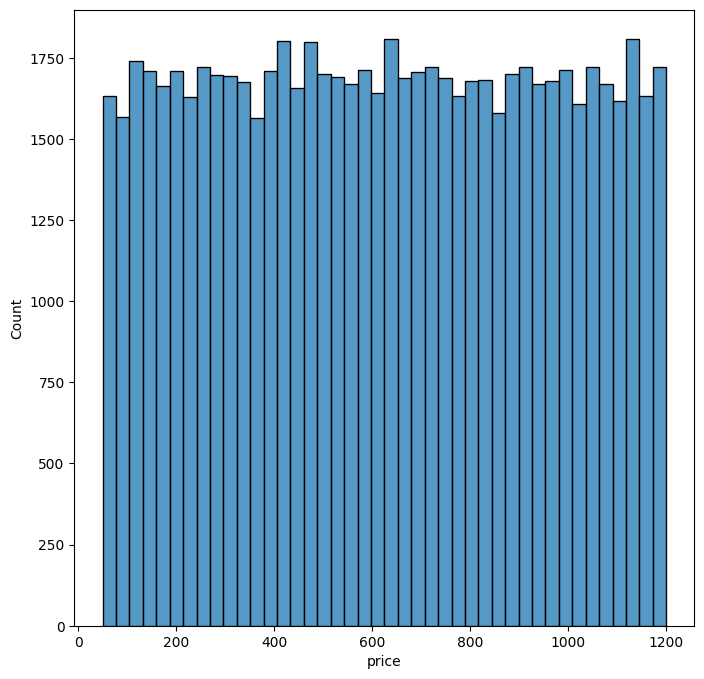

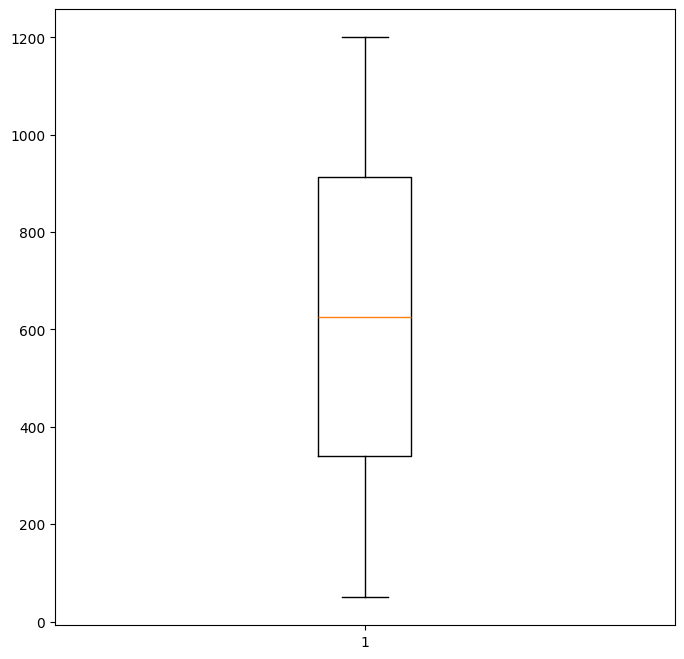

In [6]:
# Your answer goes here
plt.figure(figsize=(8,8))
sns.histplot(data=cleaned_data, x="price")
plt.figure(figsize=(8,8))
plt.boxplot(cleaned_data["price"])

### Exploring Price Relationships

To inform our pricing decision, we want to investigate some differentiating factors for pricing apartments.

Since you have an overview of the prices and their distribution, you want to investigate which features of your dataset you might use to make your pricing decision. To do so, discuss each feature of the dataset and already rule out features that will definitely not impact the pricing decision. Below you can find a brief description of each feature: 

- id: Unique identifier for an apartment
- host id: Identifier of the host offering a certain apartment
- neighborhood group: Name of a neighborhood group in which an apartment is located
- neighborhood: More fine-grained view on neighborhoods than neighborhood group
- lat: Latitude coordinate of an apartment
- long: Longitude coordinate of an apartment
- country: The country in which an apartment is located
- country code: Code of the country in which an apartment is located
- instant bookable: Boolean values if an apartment is instantly bookable
- cancellation policy: Policy for cancellation of booking
- room type: Type of apartment/room
- construction year: Year of construction of apartment
- price: Price for renting an apartment
- service fee: Fee of service
- minimum nights: Number of minimum nights to rent an apartment
- number of reviews: Number of reviews for an apartment
- review rate number:  Review rate for an apartment (1 to 5)
- calculated host listings count: Number of listings a host has
- number rooms: Number of rooms in an apartment

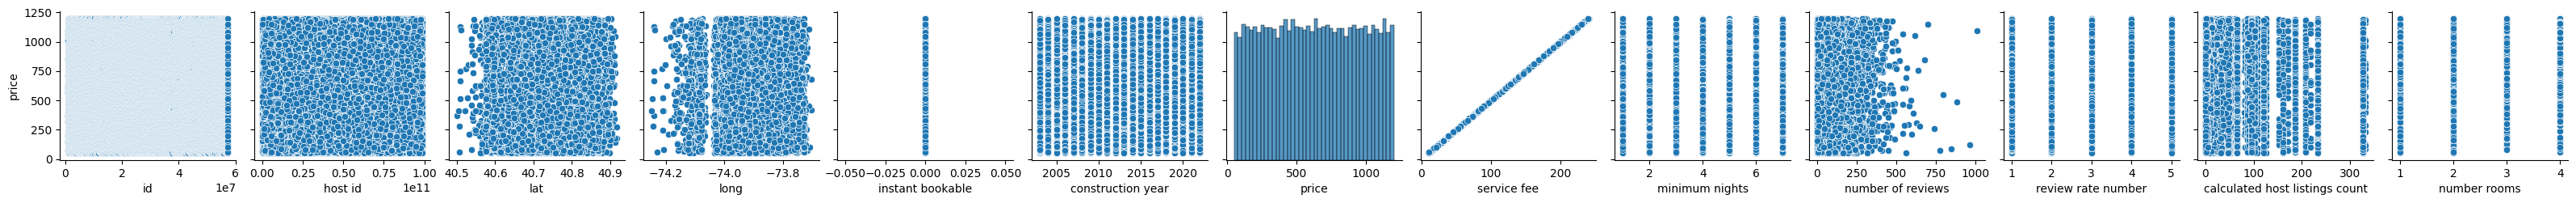

In [7]:
# Your answer goes here
sns.pairplot(cleaned_data, y_vars=['price'])

_Answer:_ We definitely can rule out the feature *instant bookable*, as all apartments have the same value. The same holds true for the features *country* and *country code* as all apartments are located in the United States. We can also rule out *host id*, *latitude*, and *longitude*, because the pairplot shows 
that these parameters are evenly distributed over the complete price range. Also, the features *host id* and *id* are not important for our pricing decision as they are unique by construction and there is no relationship between price and id. The other features seem to be more interesting, thus we include them for further analysis.

### Univariate Analysis

In the following, you want to analyze which features influence the price. You do this univariately, i.e., look at the relationship between one feature and the price individually. No matter which features you concluded to be useful in the last task, **you will consider the following seven features: service fee, minimum nights, neighborhood group, room type, cancellation policy, construction year, and the number of rooms.**

First, we look closely at the relationship between price and service fee. To do so, create a joint plot for these two attributes. What is your finding? Is this a helpful feature for our pricing decision?

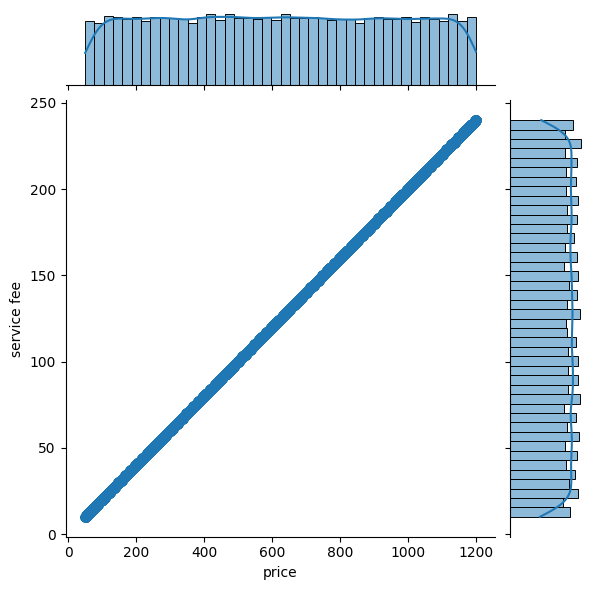

In [8]:
# Your answer goes here
sns.jointplot(x="price", y="service fee", data=cleaned_data, kind="reg")

_Answer:_ There seems to be a strong relation between service fee and price. However, as the sevice fee normaly directly depends on the price, the service fee is not a helpful feature for our pricing decision, because we will only know the service fee after we have decided for a price.

Next, we are interested in the relationship between the number of minimum nights and the price. To analyze it, create a joint plot with a regression. Describe your observation.

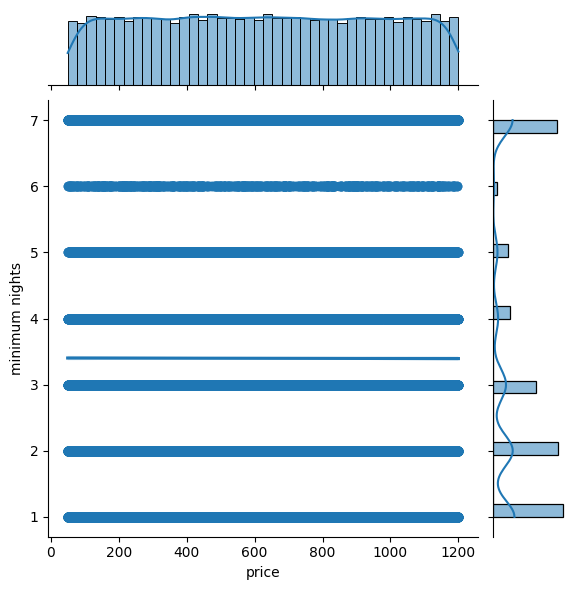

In [9]:
# Your answer goes here
sns.jointplot(x="price", y="minimum nights", data=cleaned_data, kind="reg")

_Answer:_ From the pairplot we can observe that the feature *minimum nights* is distributed evenly over the
complete price range. This is also indiacated by the regression line, which is parallel to the price-axis. Thus the number of *minimum nights* does not give us any information about the price we can achieve. We also observe that for most of the apartments the feature *minimum nights* has a value between 1 and 3 or a value of 7.



To further investigate the pricing decision, you look at the remaining five features: neighborhood group, room type, cancellation policy, construction year, and the number of rooms.
To get an overview, you decide to create box plots (including the mean) for each of these features to visualize their influence on the price. Describe your findings. Which values of the features influence the price?

<Axes: title={'center': 'price'}, xlabel='number rooms'>

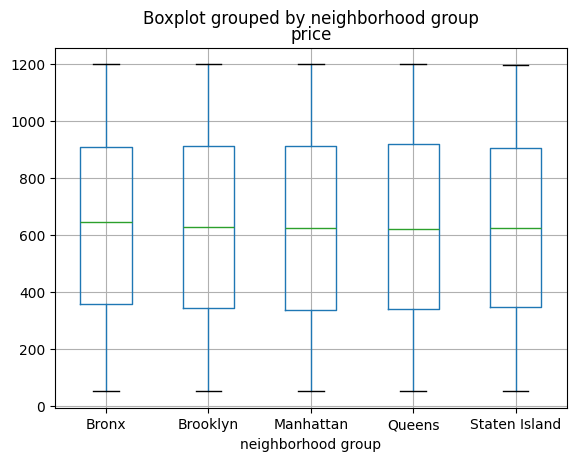

<Figure size 640x480 with 0 Axes>

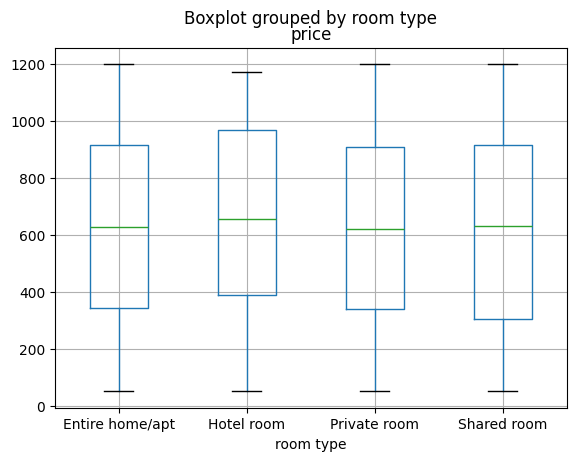

<Figure size 640x480 with 0 Axes>

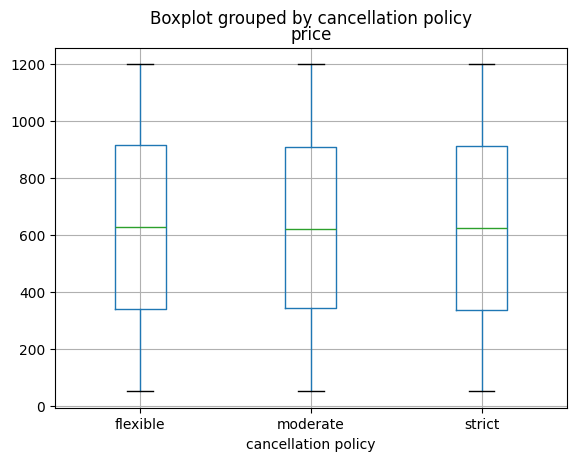

<Figure size 640x480 with 0 Axes>

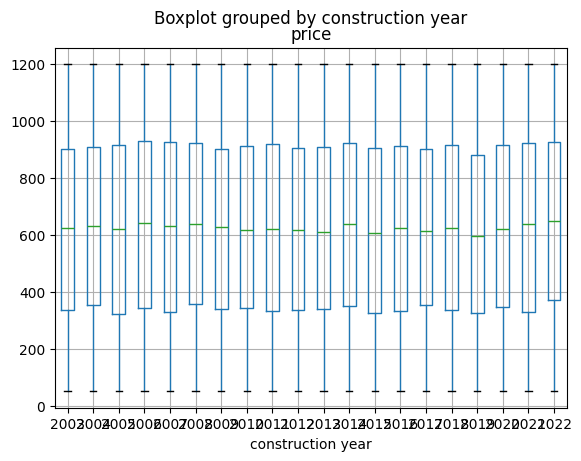

<Figure size 640x480 with 0 Axes>

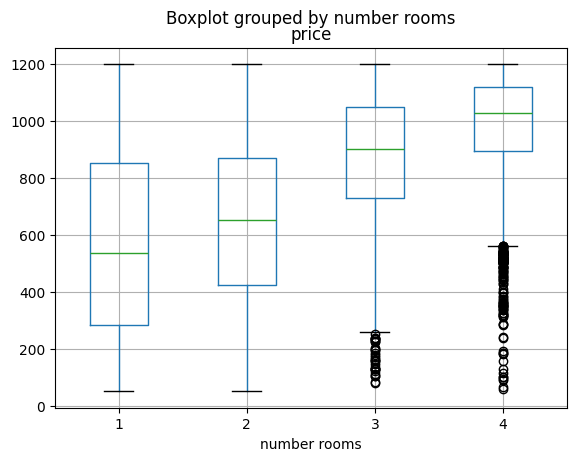

In [10]:
# Your answer goes here
cleaned_data.boxplot(column=["price"], by='neighborhood group')
plt.figure()
cleaned_data.boxplot(column=["price"], by='room type')
plt.figure()
cleaned_data.boxplot(column=["price"], by="cancellation policy")
plt.figure()
cleaned_data.boxplot(column=["price"], by="construction year")
plt.figure()
cleaned_data.boxplot(column=["price"], by="number rooms")

_Answer:_ Only the number of rooms seems to have an influence on the price. The boxplot shows that AirBnBs with more rooms have a higher price. For the other features, the boxplots for the different values of the respective feature look pretty similar. Thus these features seem to have no or only small effects on the price.

### Multivariate Analysis

As the univariate analysis of price relationships provided only limited insights, you decide to visualize some multivariate investigations of the price. **No matter what you concluded in the last section, you will use the features construction year, number of rooms, cancellation policy, room type, and neighborhood group in the multivariate analysis.**
For each pair of features, create a grouped boxplot (using the hue argument) and investigate whether the two features together allow for an explanation of price differences. In the end, conclude which combination of features should be used to make your pricing decision.

#### Multivariate Analysis for Neighborhood Group

<Axes: xlabel='cancellation policy', ylabel='price'>

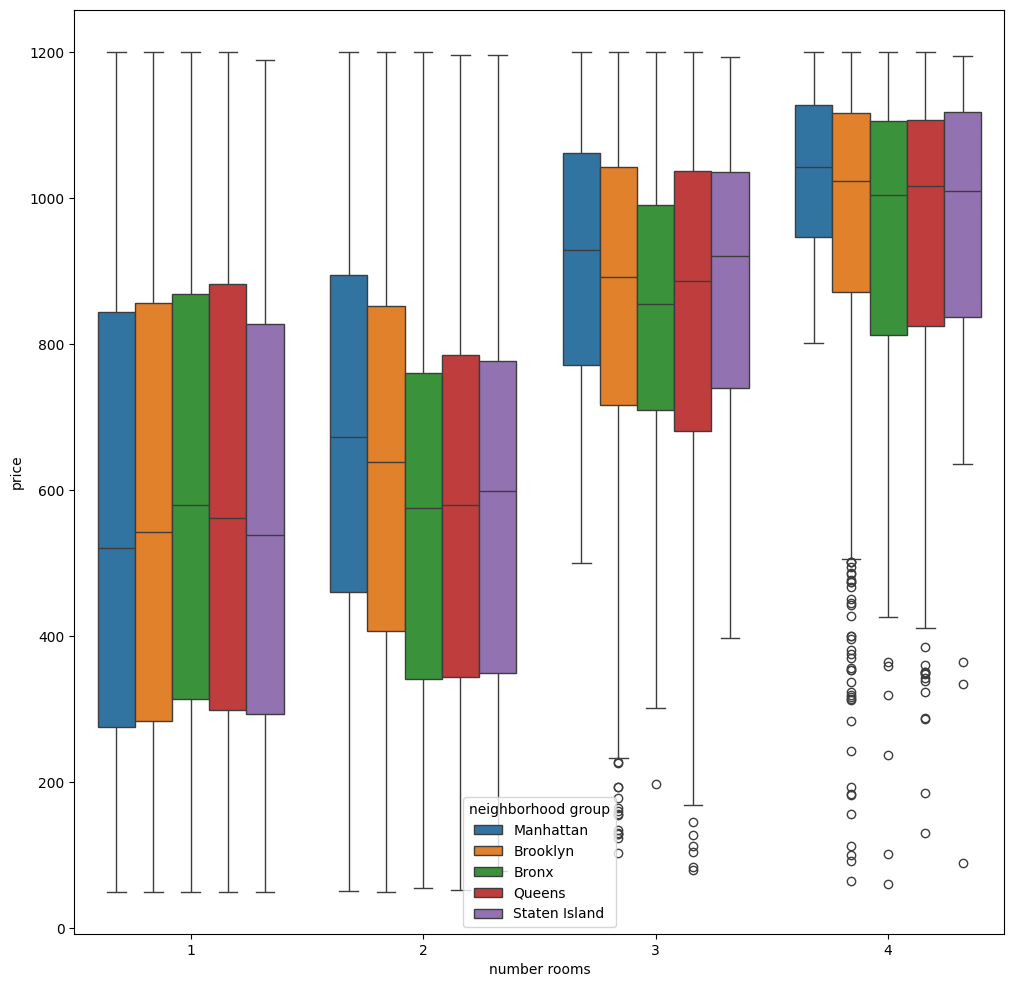

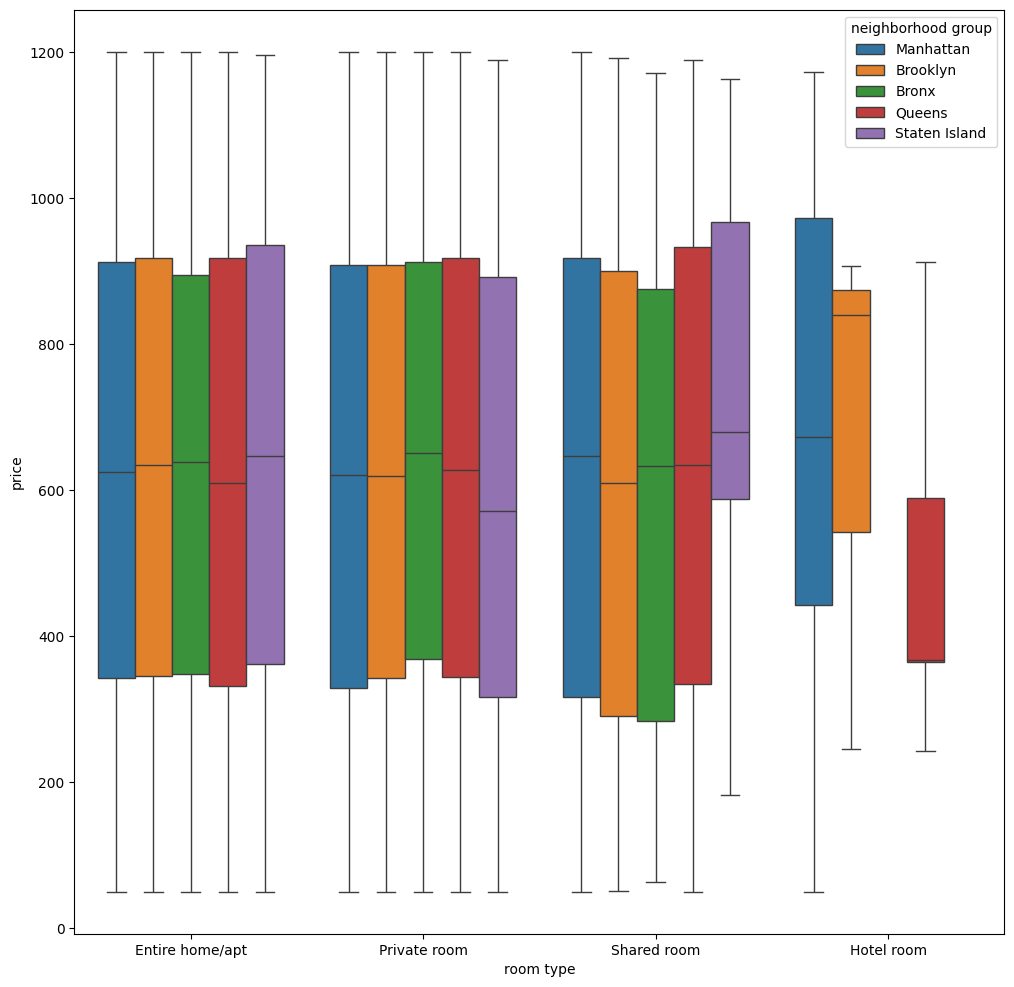

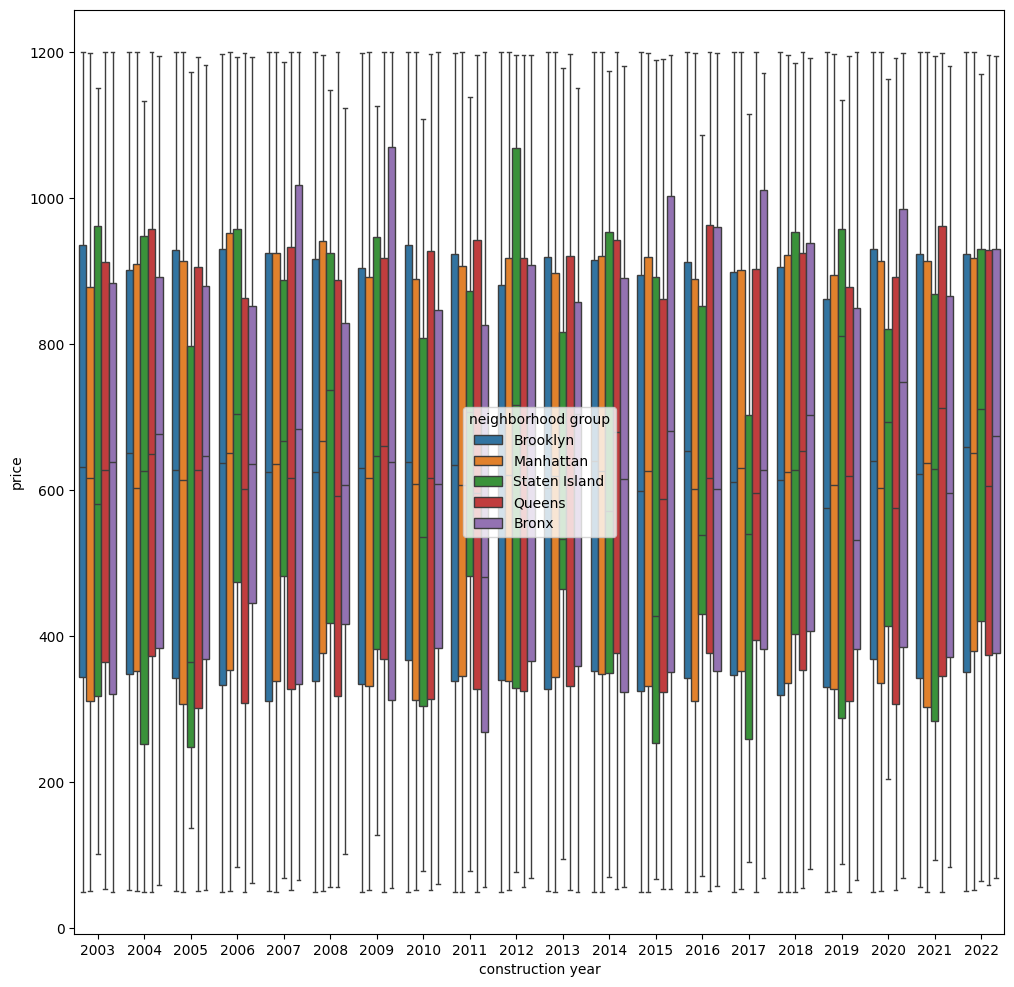

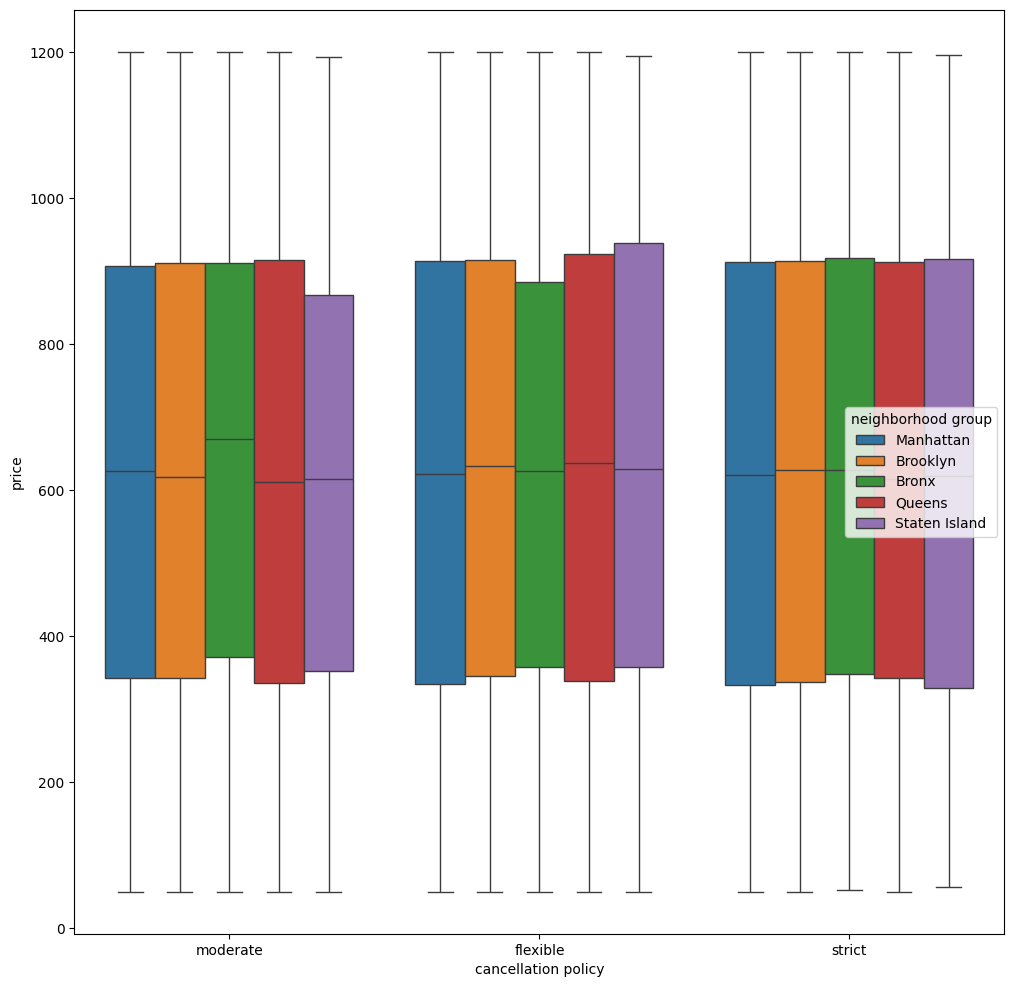

In [11]:
# Your answer goes here
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "number rooms" , y="price", hue="neighborhood group")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "room type" , y="price", hue="neighborhood group")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "construction year" , y="price", hue="neighborhood group")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "cancellation policy" , y="price", hue="neighborhood group")

_Answer:_ As already seen in the univariate analysis, we see that the *number of rooms* still has an influence on the *price* when analyzed
together with the *neighborhood group*. We also can observe that a shared room on Staten Island seems to be a bit more expensive than a
Entire home or a private room. Furthermore, the combination of *neighborhood group* and *room type* shows that a hotel room in Queens is less expensive
than a hotel room in Manhattan or Brooklyn. The combination of the feature *neighborhood group* with the features *construction year* and *cancellation
policy* does not give us additional insights into the price relationships.

#### Multivariate Analysis for Room Type

<Axes: xlabel='cancellation policy', ylabel='price'>

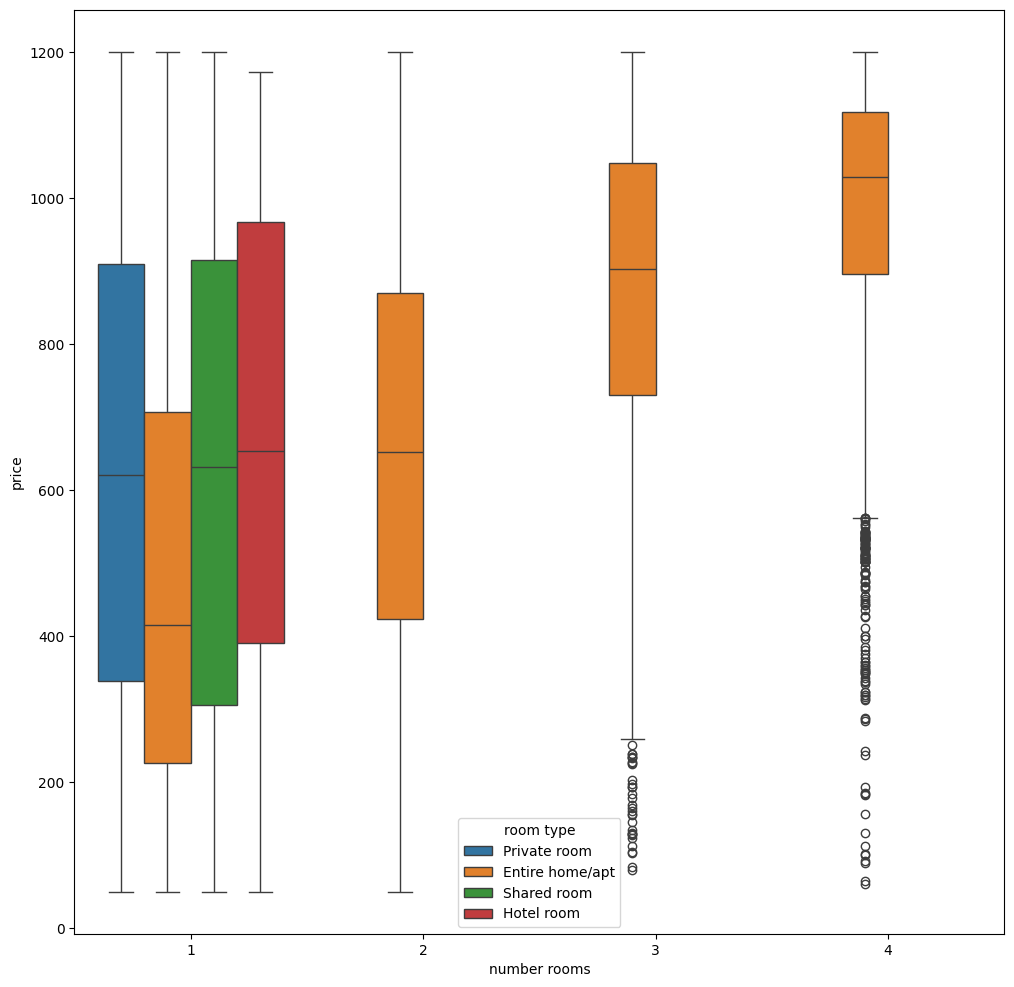

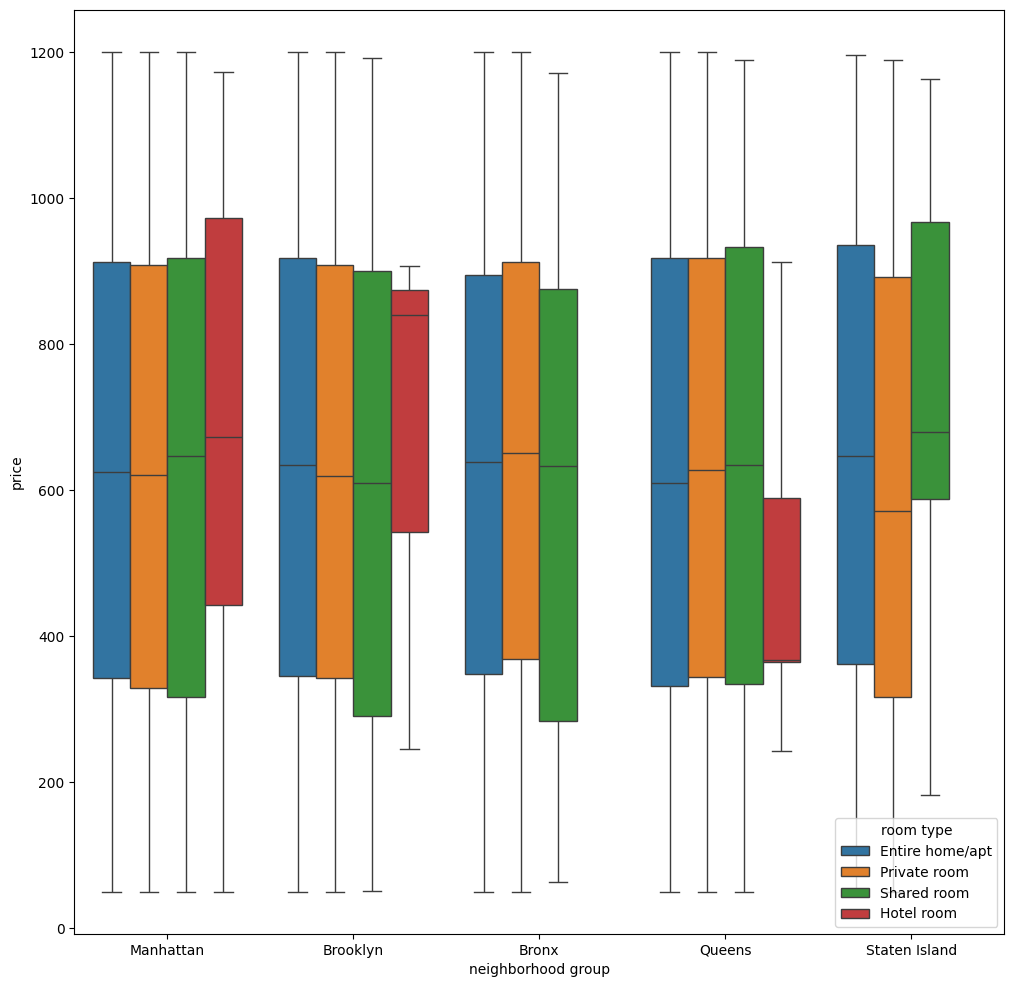

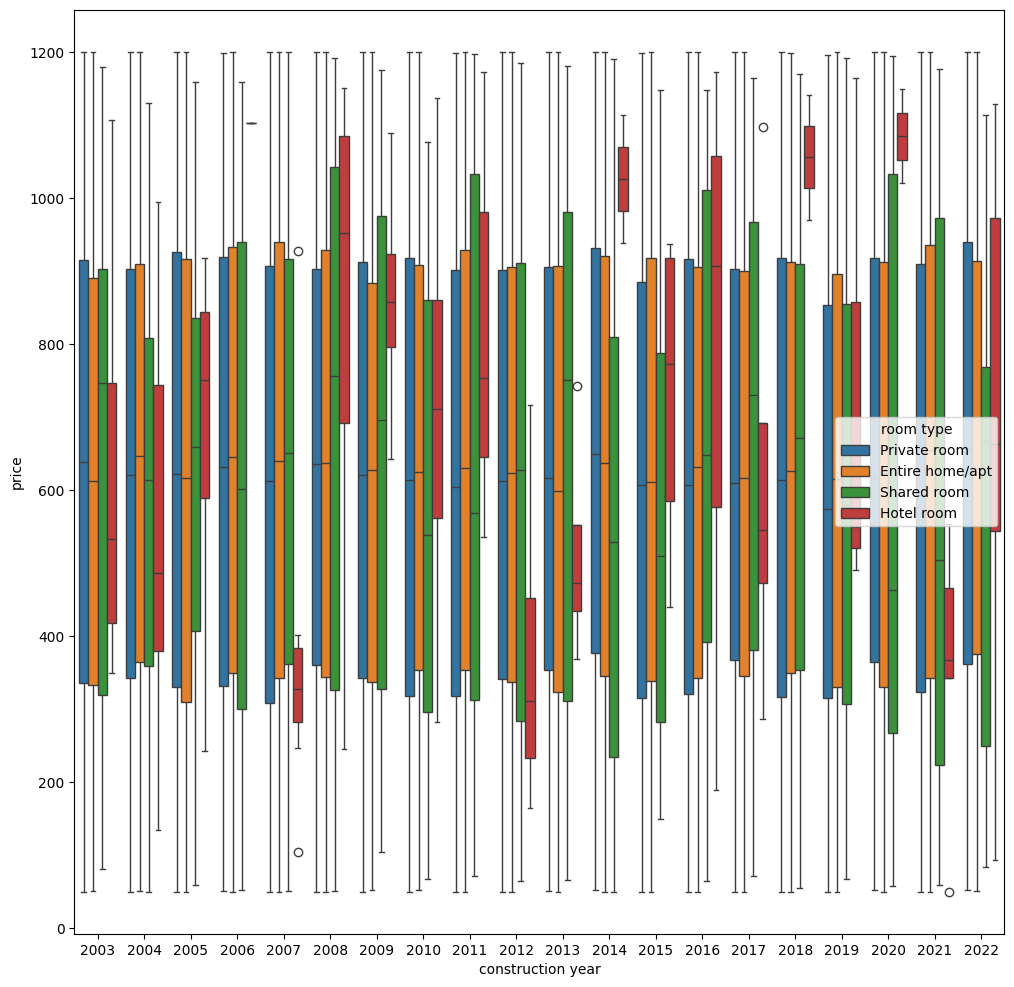

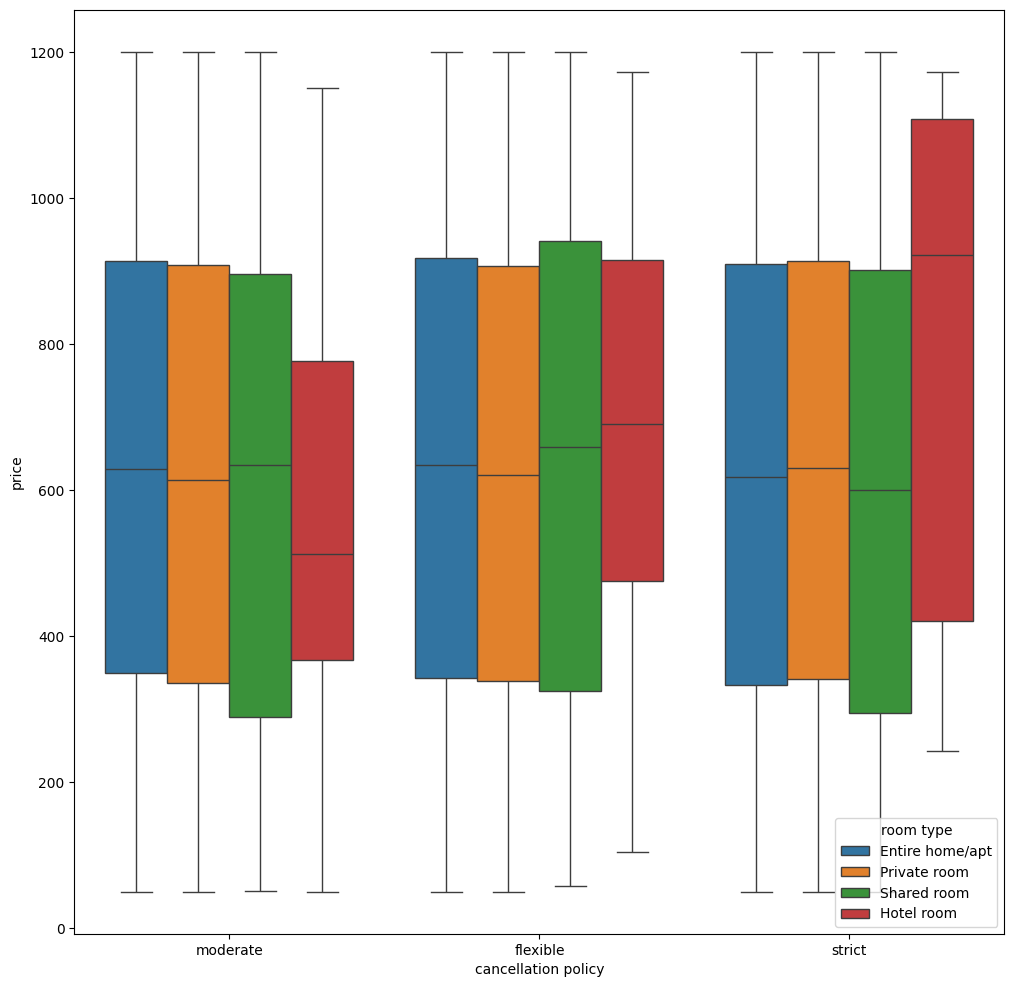

In [12]:
# Your answer goes here
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "number rooms" , y="price", hue="room type")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "neighborhood group" , y="price", hue="room type")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "construction year" , y="price", hue="room type")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "cancellation policy" , y="price", hue="room type")

_Answer:_ Here we combine the *room type* with the other four features. As in the analysis above, we can observe the effect of the
 combination of *room type* and *neighborhood group* onto the price, namely that hotel rooms in Queens are cheaper than hotel rooms in Manhattan and Brooklyn.
 If the *room type* is combined with the *construction year* we observe a lot of fluctuations for hotels, however, there is no general trend recognizable.

83


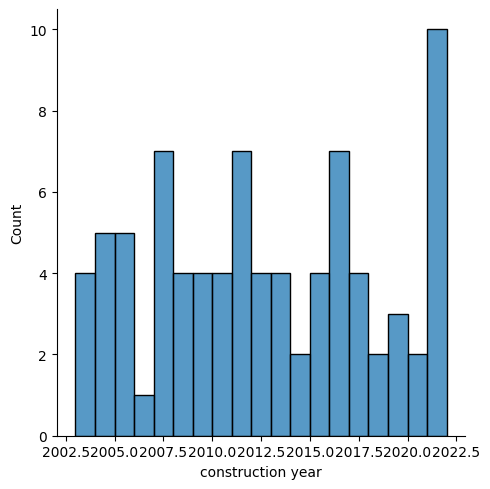

In [13]:
hotel_rooms = cleaned_data[cleaned_data['room type'] == "Hotel room" ]
print(len(hotel_rooms))
sns.displot(data=hotel_rooms, x="construction year", binwidth=1)

The low number of hotel rooms contained in the dataset, explains why there are so high fluctuations. As there are only a few hotels constructed each year a single hotel can have a big influence on the resulting boxplot if we create boxplots that consider hotels separatley.

#### Multivariate Analysis for Number of Rooms

<Axes: xlabel='cancellation policy', ylabel='price'>

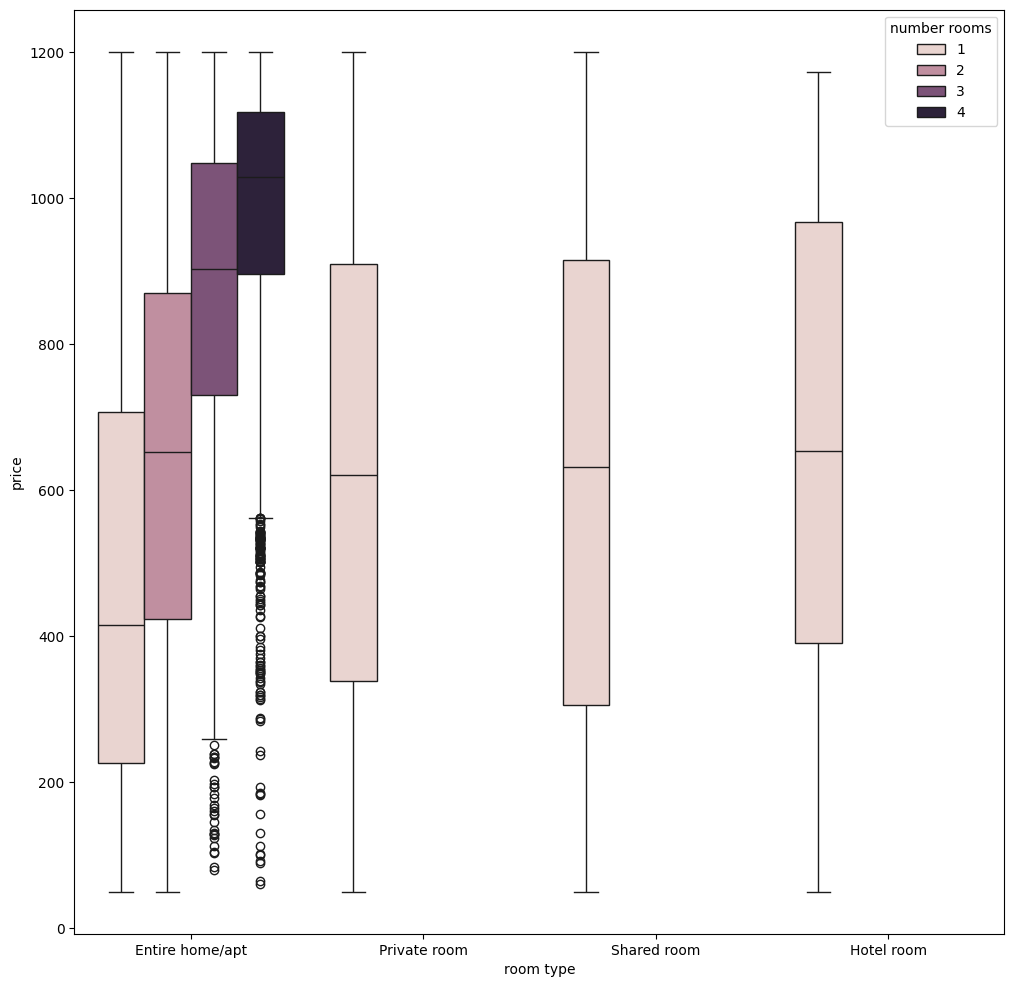

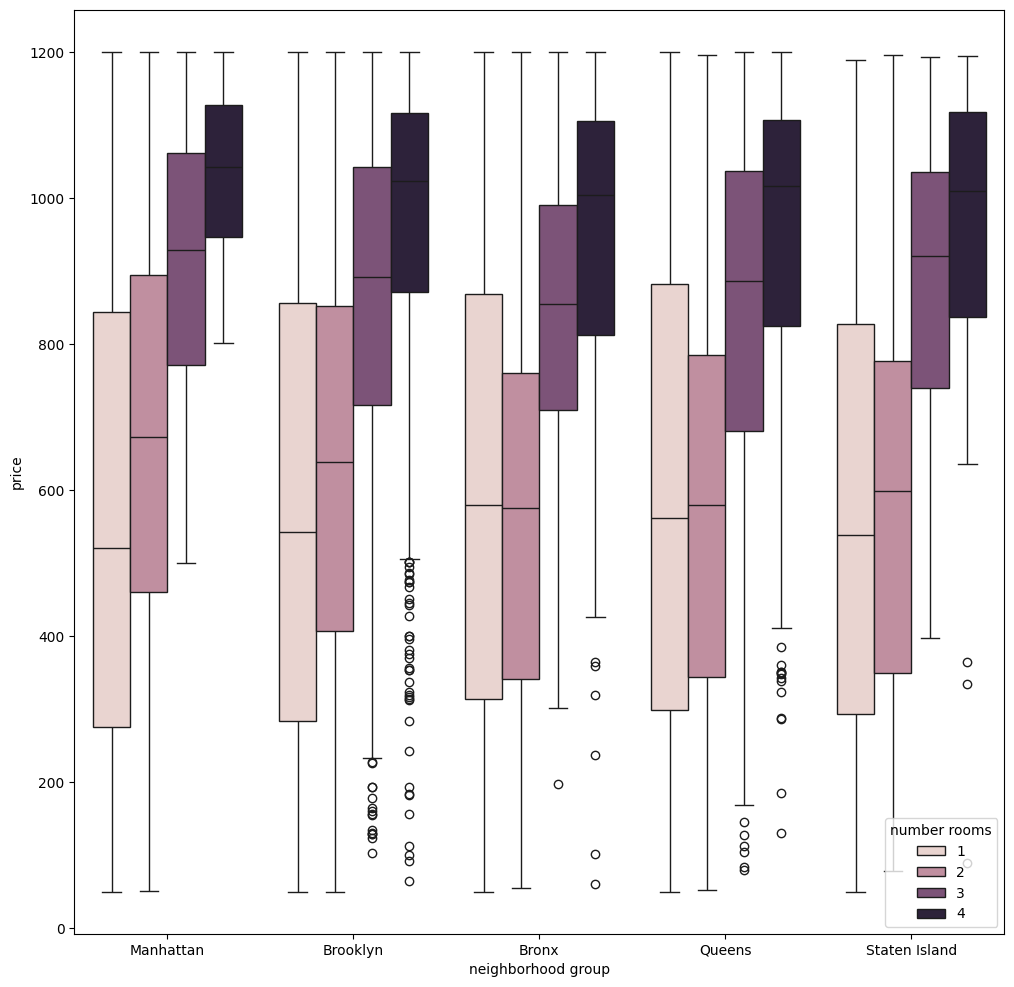

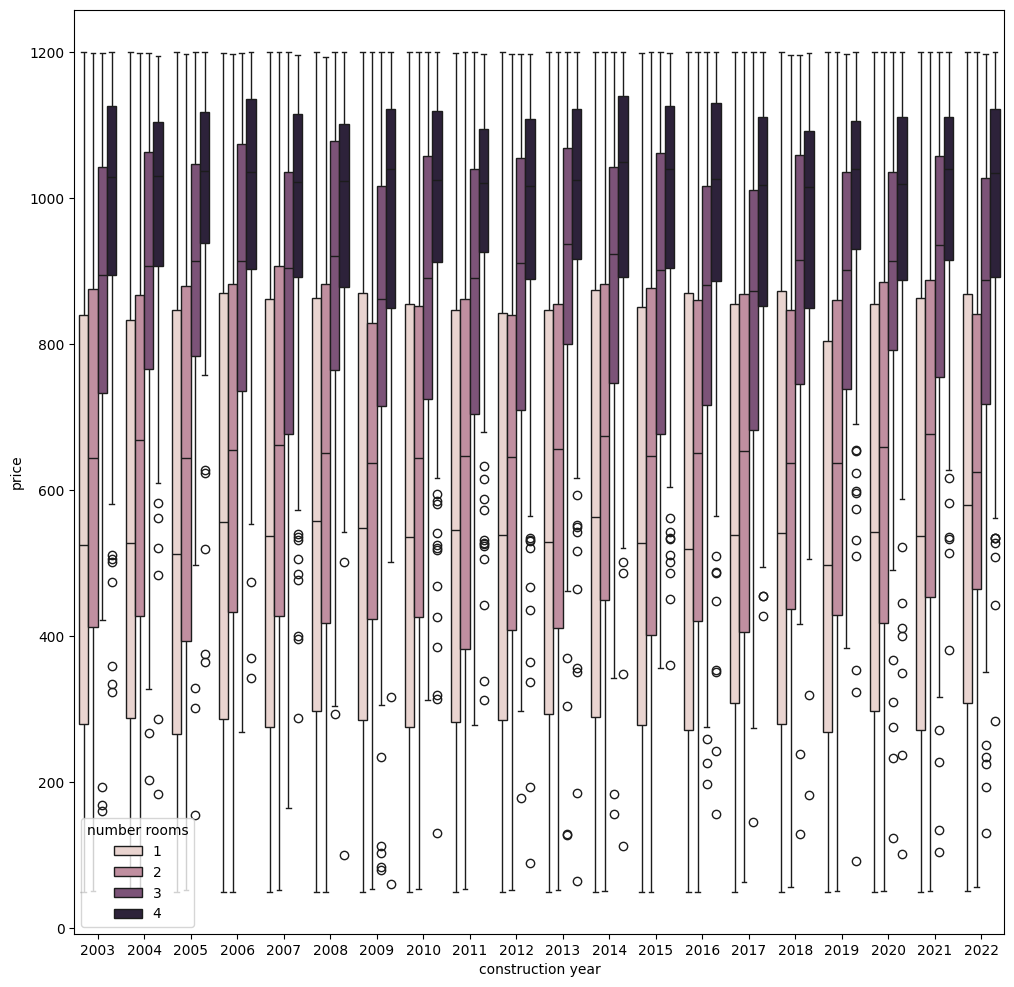

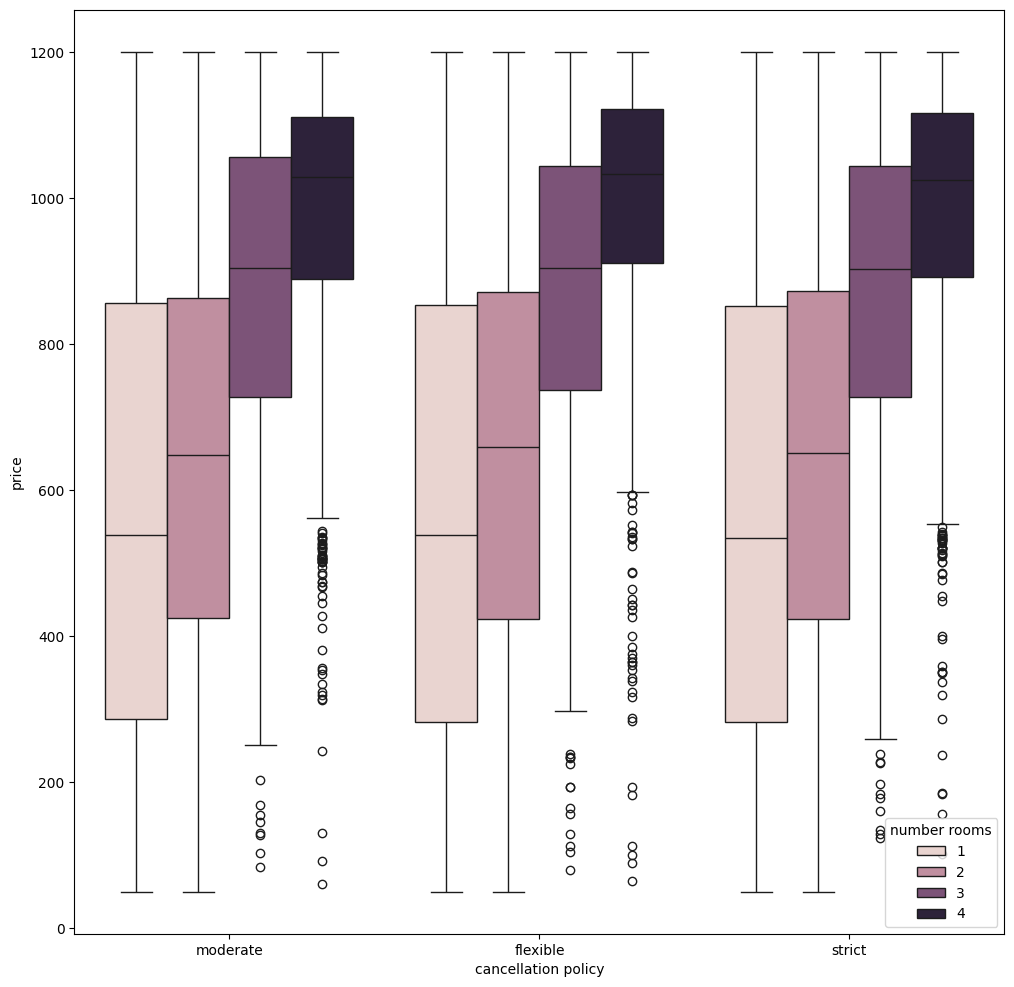

In [14]:
# Your answer goes here
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "room type" , y="price", hue="number rooms")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "neighborhood group" , y="price", hue="number rooms")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "construction year" , y="price", hue="number rooms")
plt.figure(figsize=(12,12))
sns.boxplot(data=cleaned_data, x= "cancellation policy" , y="price", hue="number rooms")

_Answer:_ From the univariate analysis we already know that the *number of rooms* alone has an influence on the *price*, thus we see in all four boxplots that the *number of rooms*
has an influence on the *price*. But we can also see that the other features mostly do not change the effect of the *number of rooms* on the price. One execption is the *number of rooms*
combined with the feature *room type*. Here we can observer that *Entire home/apt* with one room is less expensive than the other rooms types if they have one room. 

#### Multivariate Analysis for Construction Year

<Axes: xlabel='cancellation policy', ylabel='price'>

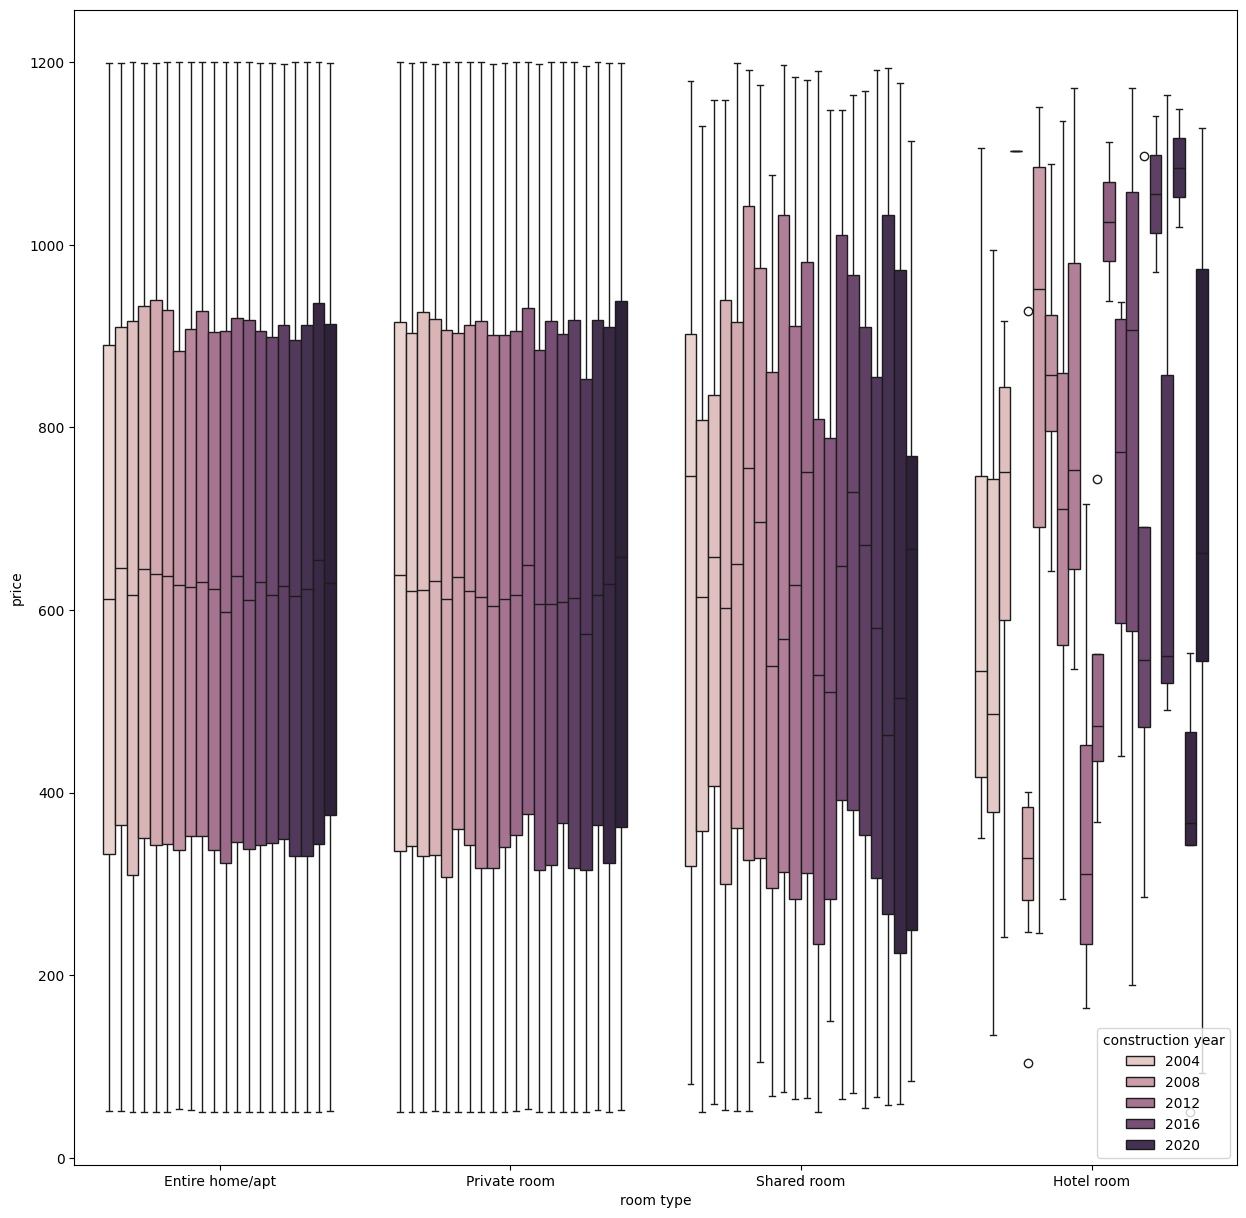

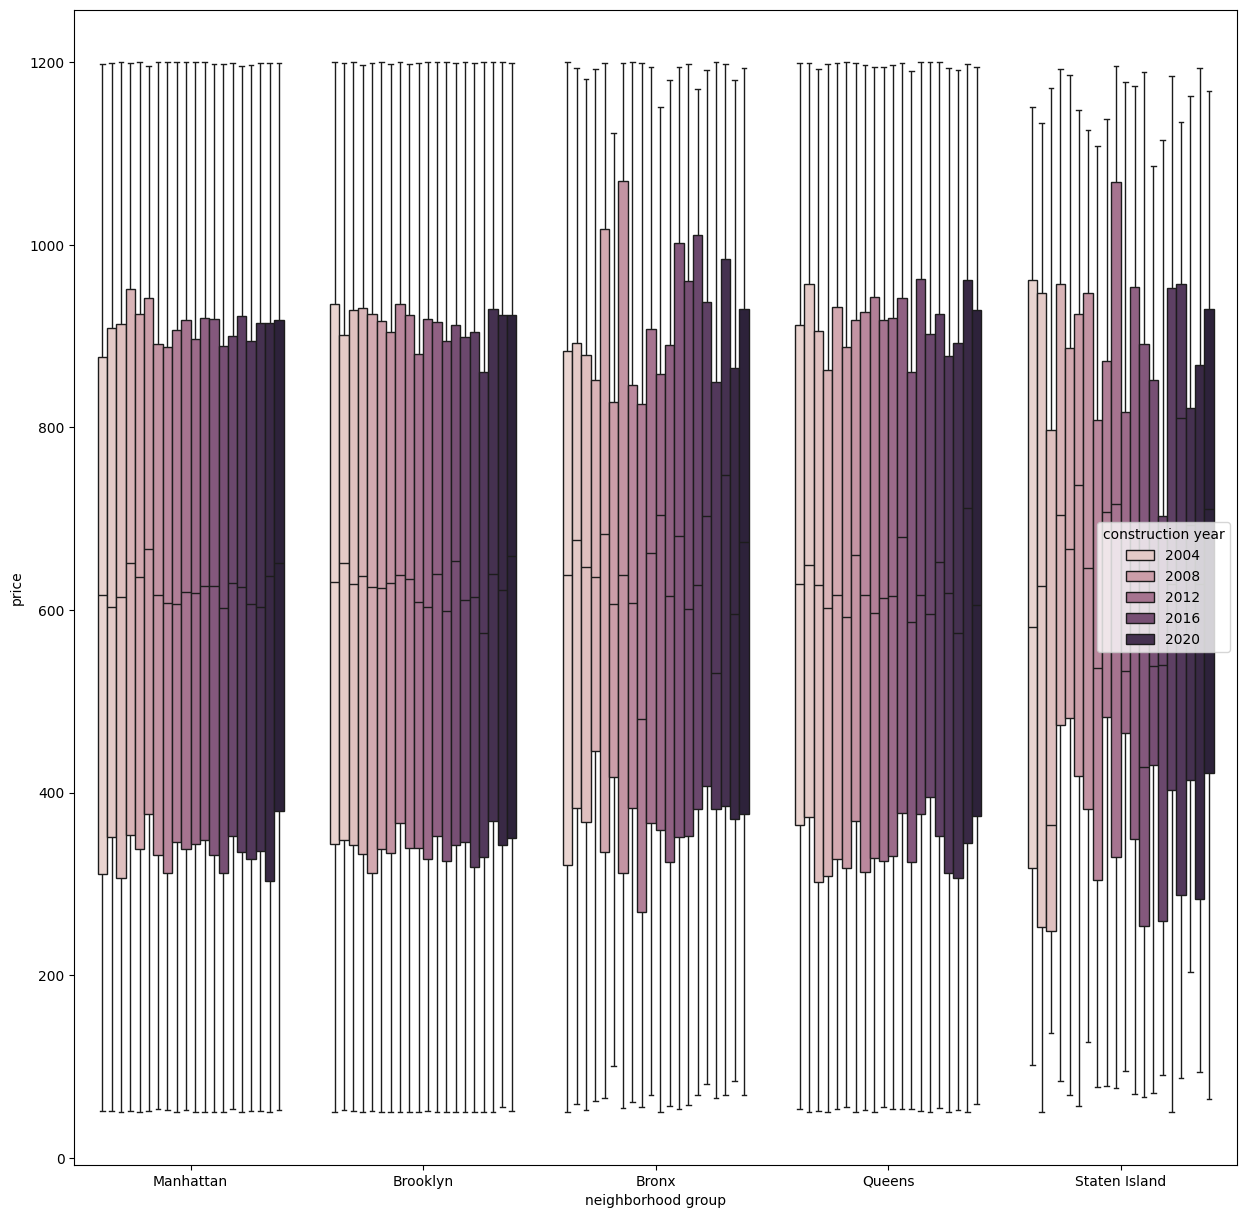

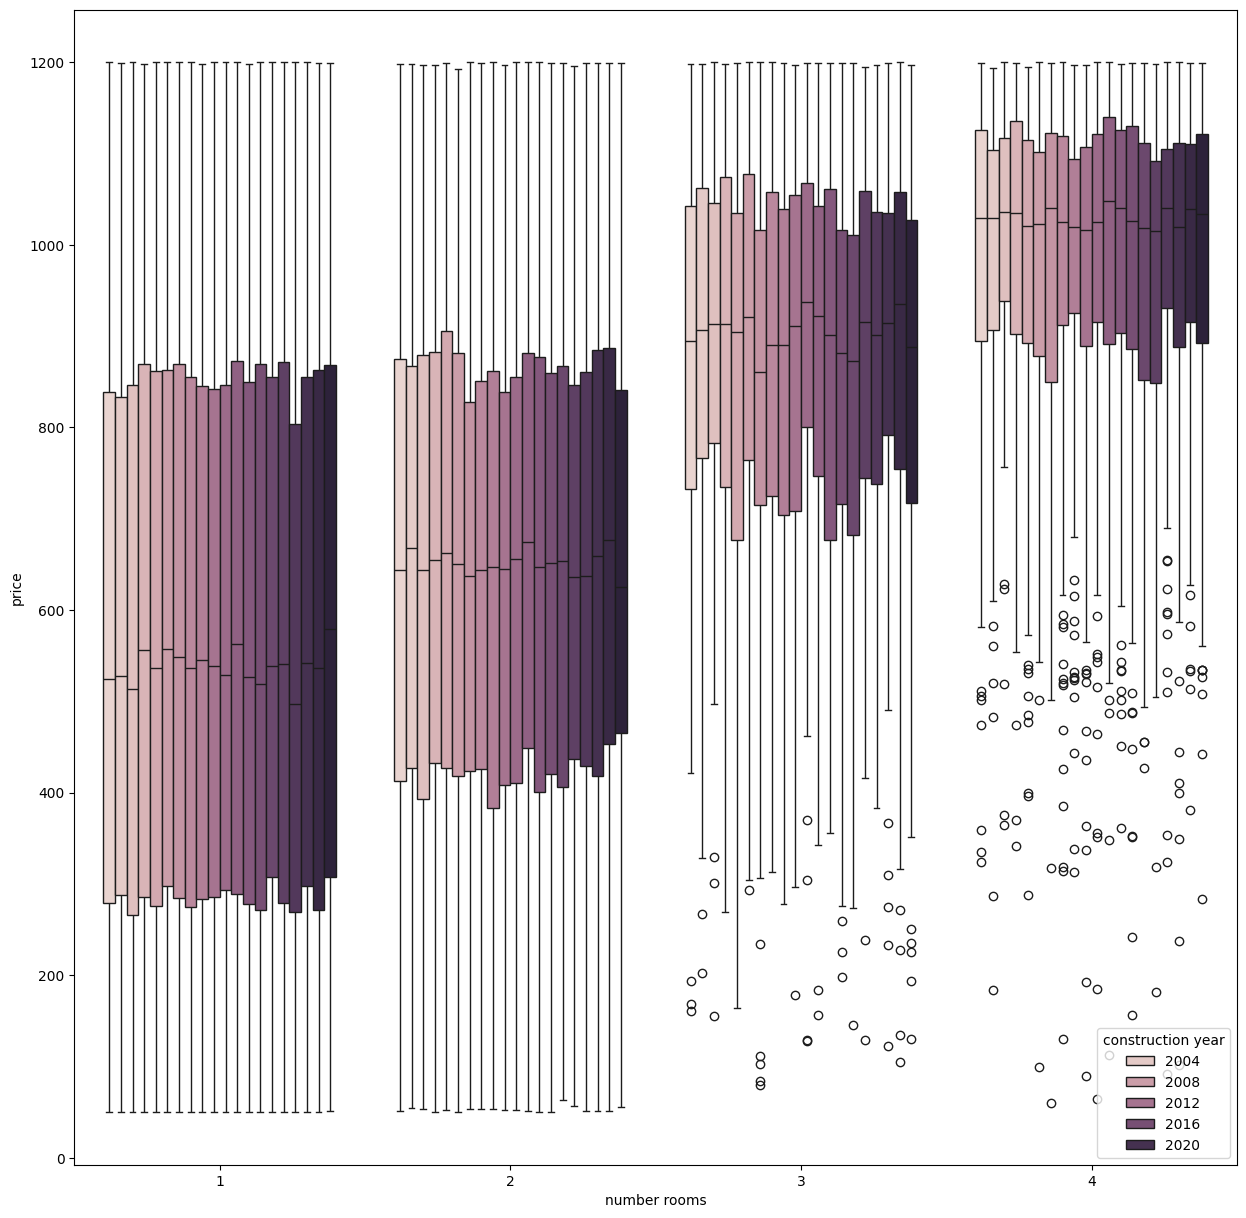

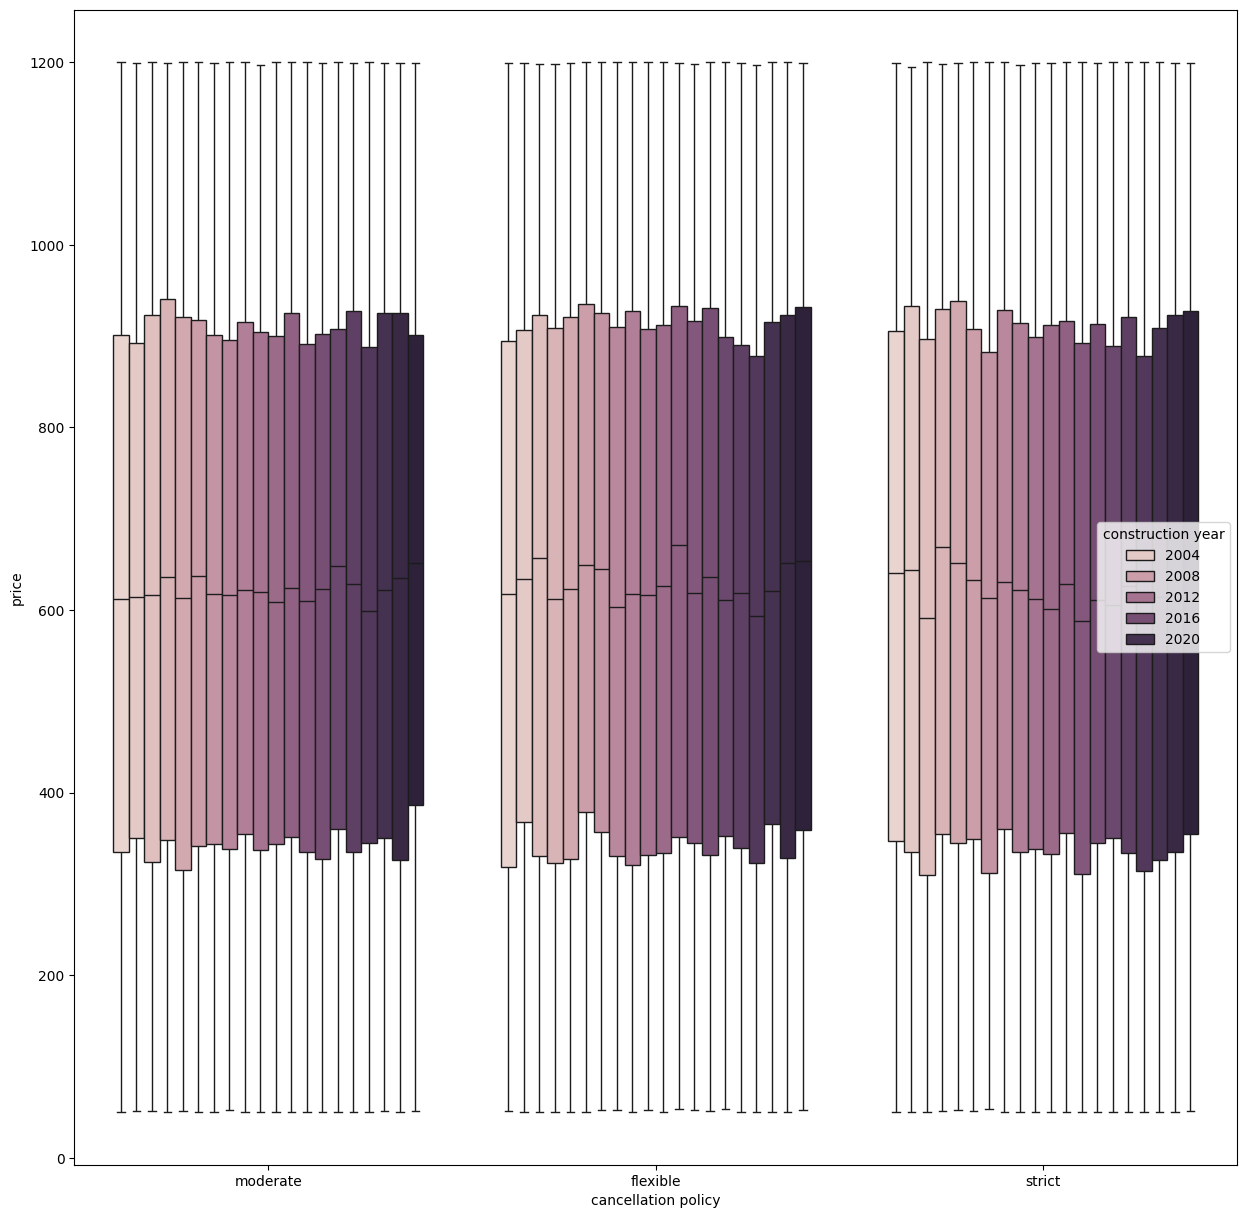

In [15]:
# Your answer goes here
plt.figure(figsize=(15,15))
sns.boxplot(data=cleaned_data, x= "room type" , y="price", hue="construction year")
plt.figure(figsize=(15,15))
sns.boxplot(data=cleaned_data, x= "neighborhood group" , y="price", hue="construction year")
plt.figure(figsize=(15,15))
sns.boxplot(data=cleaned_data, x= "number rooms" , y="price", hue="construction year")
plt.figure(figsize=(15,15))
sns.boxplot(data=cleaned_data, x= "cancellation policy" , y="price", hue="construction year")

_Answer:_ Also here we can observe the influence of the *number of rooms* on the price. We can also again observe the high price fluctuations when looking at the *construction
year* together with the *room type* Hotel room. This is again due to the low number of hotel rooms in the data set.
Apart from that the feature *construction year* in combination with one of the four other features does not seem to be capable to explain price relationships.


### Selection of Variables

Please argue: Which combinations of variables would you consider for pricing your AirBnB?

_Answer:_
As already obtained from the univariate analysis the number of rooms is a feature that should be considered for the pricing decision. The multivariate analysis showed that it might be beneficial
to combine the *number of rooms* with the *room type* if we focus on single room AirBnB´s.
In addition, the feature *room type* combined with the feature *neighborhood group* is at least for some combinations useful for making a pricing decision. Thus we would use the features
*number of rooms* combined with the *room type* and the features *room type* combined with the feature *neighborhood group* for our pricing decision.

## Question 2: Setting the Price

No matter what you have deducted from your analysis, from now on, you will continue only with three features: **The number of rooms, the neighborhood group, and the room type.**

**Enter Toby**: Toby is your long-term friend back from studying at RWTH. While you studied computer science, Toby studied business administration to become a big shot at Wall Street. He currently works in the back office of some swiss credit institute just across the corner from your office. You decide to drop by and get some of his input for your pricing decision. 

Toby proposes to first use comparables pricing to price your apartment. Comparables pricing is an established concept in economics and means that you price your apartment close to similar apartments. 
You will use different techniques to find similar apartments and set a price.

## Baseline

First, you want to set a baseline to compare against. The baseline should always use the average price of all apartments as a recommended price. Evaluate on a test set of 5%. The same test set should also be used later (you can use the random_state argument in scikit learn's train_test_split, but you need to stay consistent for different questions).

In [16]:
# Your answer goes here
random_state = 0

from sklearn.model_selection import train_test_split

cleaned_data = read_dataset("AirBnB_cleaned.csv")

price_df = cleaned_data[["number rooms", "neighborhood group", "room type", "price"]]

train, test = train_test_split(price_df, test_size=0.05, random_state=random_state)

mean_price = price_df["price"].mean()

print("Mean price: ", mean_price)

Mean price:  625.4636797380085


## Decision Tree

Using a decision tree, you try to price your apartment according to similar apartments. 

In the following, we want to know the price ranges for renting AirBnBs. To use decision trees, you need to discretize prices. We use the following price bins:


- [50, 200]
- (200, 400]
- (400, 600]
- (600, 800]
- (800, 1000]
- (1000, 1200]

We add the attribute "Price_Bins" using the discretization mentioned above for each apartment. For example, if an apartment costs 404, it is put into the bin (400, 600].

In [17]:
# Your answer goes here

# The dataset only contains price values between 50 and 1200
price_df["Price_Bins"] = pd.cut(price_df["price"], bins=[50,200,400,600,800,1000,1200])

C:\Users\Sanjida Ivy\AppData\Local\Temp\ipykernel_6288\3074678730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df["Price_Bins"] = pd.cut(price_df["price"], bins=[50,200,400,600,800,1000,1200])


Consider the extended dataset from the previous task. Use 'number rooms,' 'room type,' and 'neighborhood group' as descriptive features and "Price_Bins" as the target feature. Create a test and training set like before.

In [18]:
# Your answer goes here

train, test = train_test_split(price_df, test_size=0.05, random_state=random_state)

descriptive_features = ["number rooms", "neighborhood group", "room type"]
target_features = ["Price_Bins"]

tree_data = price_df
columns = tree_data.columns

descriptive_features = columns[:-2]
label = columns[-1]

for column in tree_data.columns:
    tree_data[column]= tree_data[column].astype(str)

data_descriptive = price_df[descriptive_features].values
data_label = price_df[label].values

C:\Users\Sanjida Ivy\AppData\Local\Temp\ipykernel_6288\3651877088.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_data[column]= tree_data[column].astype(str)
C:\Users\Sanjida Ivy\AppData\Local\Temp\ipykernel_6288\3651877088.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_data[column]= tree_data[column].astype(str)
C:\Users\Sanjida Ivy\AppData\Local\Temp\ipykernel_6288\3651877088.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Generate a decision tree in which the minimum number of samples for splitting is ten and use entropy. What is the system's entropy?

Note: For this task, you must use the p_decision_tree library.

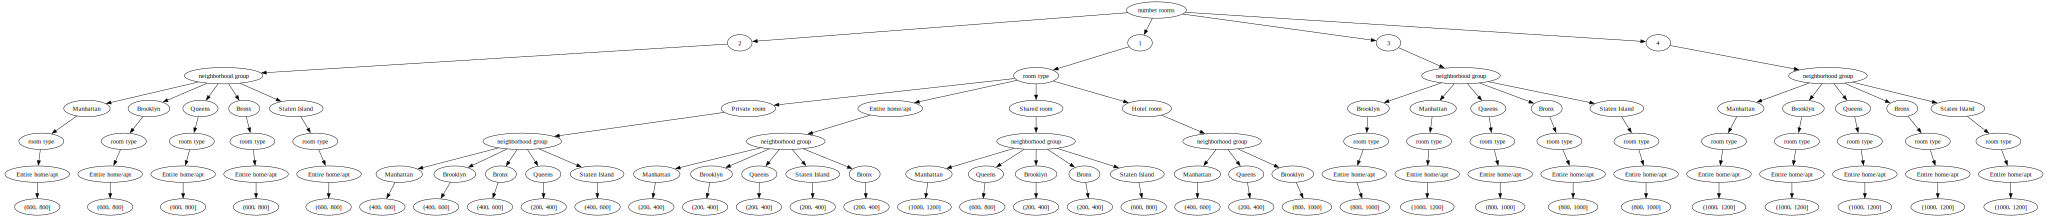

System entropy:  2.5851882800212325


In [19]:
# Your answer goes here

from p_decision_tree.DecisionTree import DecisionTree

decisionTree = DecisionTree(data_descriptive.tolist(), descriptive_features.tolist(), data_label.tolist(), "entropy")
decisionTree.id3(0,10)

dot = decisionTree.print_visualTree(render=True)

display(dot)

print("System entropy: ", format(decisionTree.entropy))

What is the first feature the decision tree splits on?

_Answer:_ The first feature the decision tree splits on is "number of rooms".



Since it doesn't make sense to set a price range for renting a room, we need to fix a price. For simplicity, we use the means of the bins, i.e., 125, 300, 500, 700, 900, and 1100. For example, if a room were categorized in the bin (200, 400], it would have the price of 300.

What prices are possible given your decision tree for:

- Manhattan, 1-room, Private room
- Staten Island, 1-room, Shared room

_Answer:_

The prices are:

- Manhattan, 1-room, Private room => 500
- Staten Island, 1-room, Shared room => 700

What is the proposed price of the decision tree for our apartment? Store it in a variable for later usage.

In [20]:
# Your answer goes here
price_binary_tree = 700

To evaluate how good our decision tree is for determining price categories, we want to measure the error of the predictions on the test set. To do so, the IDS team provided you helper functions below.

In [21]:
def get_name_value_dict(graph):
    id_label_dict = {}
    root = decisionTree.root
    visited = set() # Set to keep track of visited nodes of graph.

    def dfs(visited, graph, node):#function for dfs 
        id_label_dict[node.name] = node.value
        if node not in visited:
            if node.next:
                id_label_dict[node.next.name] = node.next.value
            visited.add(node)
            if node.childs:
                for child in node.childs:
                    if child is not None:
                        dfs(visited, graph, child)
            elif node.next:
                if node.next.childs:
                    for child in node.next.childs:
                        if child is not None:
                            dfs(visited, graph, child)
    dfs(visited, decisionTree, root)
    return id_label_dict

def get_predictor(tree):
  id_label_dict = get_name_value_dict(tree)
  dotplus = pydotplus.graph_from_dot_data(tree.source)
  G = networkx.nx_pydot.from_pydot(dotplus)
  root = [n for n,d in G.in_degree() if d==0][0]
  paths = []
  for node in G:
      if G.out_degree(node)==0: #it's a leaf
          paths.append(networkx.shortest_path(G, root, node))
  new_paths = []
  for path in paths:
      for name, value in id_label_dict.items():
          path = ([p.replace(name, value) for p in path])
      new_paths.append(path)
  predictor = {}
  for path in new_paths.copy():
    target = path[-1]
    classification = tuple(path[:-1])
    predictor[classification] = target
  return predictor

def get_prediction_features(predictor):
    features = set()
    for key in predictor:
        i = 0
        while i <= len(key)-2:
            features.add(key[i])
            i +=2
    return features
            
def get_predicted_bin(instance, features, predictor):
  feature_values = {}
  for feature in features:
      feature_values[feature] = instance[feature]
  possible_paths = predictor.keys()
  i=0
  while i<=len(feature_values):
    attribute = [path[i] for path in possible_paths][0]
    if attribute in predictor.values():
      break
    feature_value = feature_values[attribute]
    candidates = []
    for el in possible_paths:
      if str(el[i+1]) == str(feature_value):
        candidates.append(el)
    possible_paths = candidates.copy()
    i+=2
  return predictor[possible_paths[0]]



### Dot is your visual decision tree. Adjust the naming if needed
predictor = get_predictor(dot)
features = get_prediction_features(predictor)

To predict the price bin for each instance of your test set, apply the function get_predicted_bin using the variables *predictor* and *features* provided above.

In [22]:
# Your answer goes here

test["predicted_price"] = test.apply(lambda row : get_predicted_bin(row, features, predictor), axis=1)

You predicted a price range for AirBnBs in your test set. However, since you cannot enter a price range for renting an apartment, we have to map the range of bins to one value. To do so, we use the mean of bins, as explained before, to predict the price. Given that, compute the mean absolute error between the prediction from the decision tree and the real price provided in the dataset. What is the mean absolute error?

In [23]:
# Your answer goes here

test["predicted_price_num"] = test.apply(lambda row : (int(row["predicted_price"].split(",")[0][1:]) + int(row["predicted_price"].split(",")[1][:-1])) / 2, axis=1)

test["mae"] = test.apply(lambda row : abs(row["price"] - row["predicted_price_num"]), axis=1)

print("The mean absolute error is: ", test["mae"].sum() / len(test))


The mean absolute error is:  273.47756138865367


## Clustering

Another way to do comparables pricing is to find similar apartments using clustering. Each calculated cluster represents one or more similar apartments in the dataset. For each cluster, you calculate the mean price as a representative price. To predict the price for new apartments, you assign them to an existing cluster and give the mean price as prediction.

Use the same features you used in the decision tree for the clustering as well (**number rooms, neighborhood group, room type**), and remember that your dataset is still split into a training and test set.

In this task, you will use the k-means algorithm.
*Note: To keep results comparable, please use 100 for random state and n_init when initializing the clustering algorithm. Also, remember to use the same test and training set as in the previous tasks to compare performances.*

### Encoding 

K-means tries to calculate the distance between different data points. Since some of the features you want to use are not numeric, apply one-hot encoding to be able to use distance measures. Use the preprocessing module of sklearn to prepare your dataset for clustering.

In [24]:
# Your answer goes here
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

temp_df = train[["number rooms", "neighborhood group", "room type"]]

# preprocess the dataset
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

# split categorical vs numerical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(temp_df )
categorical_columns = categorical_columns_selector(temp_df )

# create a preprocess that can handle both categorical and numeric data
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

preprocessor.fit(temp_df)
X = preprocessor.transform(temp_df)

### Choosing number of clusters

In k-means, the number of wanted clusters is a parameter one can decide on. Since this is information you do not have at this time, you choose to use the data to decide.

You cluster on the training dataset by using `k` number of clusters where `k` is between 4 and 15. Since you are interested in the price, for each clustering, you calculate the **standard deviation of the mean prices for the clusters**. Therefore, for each clustering:
1. Calculate the mean price for each of the resulting clusters.
2. Calculate the standard deviation of the mean prices calculated in 1.

Plot a diagram where on the `x-axis` you will have the *number of clusters used* and on the `y-axis` the *standard deviation of the means*.

In your opinion, which amount of clusters makes more sense? Explain your answer.

In [25]:
# Your answer goes here
clustering_dict = {}

for k in range(4, 16):
	kmeans = KMeans(n_clusters=k, random_state=100, n_init=100).fit(X)
	clustering_dict[k] = kmeans

In [26]:
# We split the actual clustering and the evaluation of the clustering in two cells, so we don't have to run the clustering again if we want to change the evaluation

train["price"] = train["price"].astype(int)

clustering_result_dict = {}

for k in range(4, 16):
	train = train.assign(cluster=clustering_dict[k].labels_)
	clustering_result_dict[k] = (train.groupby("cluster")["price"].mean(), train.groupby("cluster")["price"].mean().std())

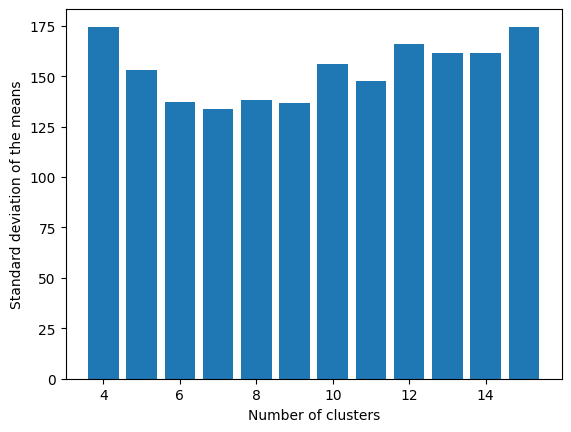

In [27]:
import matplotlib.pylab as plt

plt.bar(clustering_result_dict.keys(), [clustering_result_dict[k][1] for k in clustering_result_dict.keys()])
plt.xlabel("Number of clusters")
plt.ylabel("Standard deviation of the means")
plt.show()

_Answer:_

The standard deviation of the means should be a measure of the differences between the different clusters and their centers. A higher one should mean that the clusters have higher differneces in the prices, therefore there may be a feature, that has an influence on the price of the apartments with this feature.

While we have already run the k-means algorith for the different clusters it may be better to choose a lower number of clusters due to the time complexity. This is just for clustering, not for the prediction.

Four clusters look like a good choice, quite high standard deviation of the means while being a low number. Because the clustering is already done, it is fine to just choose a clustering with a high  standard deviation of the means.

**Note:** No matter the conclusion made in the previous task, from now on, you use the clustering model with **9 clusters** for predicting the price for your apartment and evaluating the clustering technique.

In [28]:
train = train.assign(cluster=clustering_dict[9].labels_)

clustering = clustering_dict[9]
clustering_means = clustering_result_dict[9][0]

### Pricing your apartment

To predict the price for your apartment, calculate in which cluster your apartment would be and use the mean value of the cluster as a possible price.

In [29]:
# Your answer goes here
# cluster for 9 clusters

our_apartment = pd.DataFrame([{"number rooms": "2", "neighborhood group": "Manhattan", "room type": "Entire home/apt"}])

our_X = preprocessor.transform(our_apartment)


price_clustering = clustering_result_dict[9][0][clustering_dict[9].predict(our_X)[0]]

print("The predicted price is: ", price_clustering)


The predicted price is:  719.2113924050633


### Evaluating clustering

You want to evaluate how well your clustering worked. In your case, two things can be evaluated:

1.   Whether the clustering technique can group similar apartments together
2.   Whether other people determine the price of their apartment as you did, meaning whether similar apartments get a similar price

You are going to evaluate the clustering technique visually. The IDS team provides you with the following fancy code that reduces your input to two dimensions.

In [30]:
x_train = train[["number rooms", "neighborhood group", "room type"]]

In [31]:
import umap.umap_ as umap

#Preprocessing numerical
full_data = x_train # use the train dataset here
numerical = full_data.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = sklearn.preprocessing.PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = full_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)
embedding = umap.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components,
                                                fit1._initial_alpha, fit1._a, fit1._b,
                                                fit1.repulsion_strength, fit1.negative_sample_rate,
                                                200, 'random', np.random, fit1.metric,
                                                fit1._metric_kwds, False, {}, False)

# Extracting the resulting dimensions
dimension1 = embedding[0].T[0]
dimension2 = embedding[0].T[1]

d:\IntroductionToDataScienceProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Sanjida Ivy\AppData\Local\Temp\ipykernel_6288\1824568836.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.64213165  1.69491225  1.44297507 ... -0.64213165 -0.64213165
  1.69491225]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
d:\IntroductionToDataScienceProject\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\IntroductionToDataScienceProject\venv\Lib\site-packages\sklearn\utils\deprecation.

Create a scatter plot from the two dimensions and use the cluster labels for coloring the data points. Use the train set for the visualization. Discuss the result.

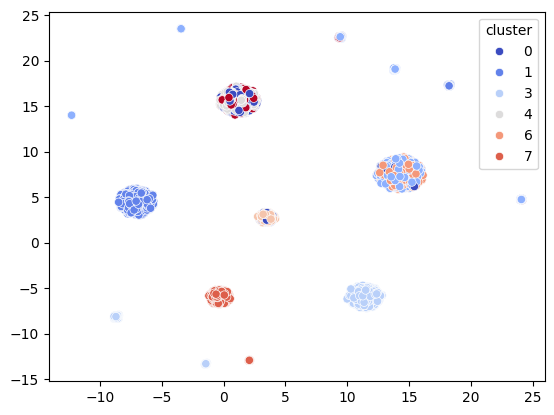

In [32]:
# Your answer goes here

sns.scatterplot(x=dimension1, y=dimension2, data=train, hue=train["cluster"], palette="coolwarm")

plt.show()

_Answer:_

In the plot we see six clusters with some outliners. The cluster near (10, 0) and the one near (2.5, 12.5) both contains datapoints from different clusters. The data was clustered with a cluster count of 9, therefore reducing the cluster may improve the results.

There are no data points for cluster 2 and 5.


We next evaluate whether similar apartments (considering the attributes we chose) get similar prices. To do this, we use our test set. Assign each apartment of the test set to the nearest centroid. Predict the price of the apartments in the test set by taking the mean price of the cluster they was assigned to. Calculate the mean absolute error between the predicted and real prices.

In [33]:
# Your answer goes here

temp_test = test[["number rooms", "neighborhood group", "room type"]]

test_x = preprocessor.transform(temp_test)
test = test.assign(cluster=clustering.predict(test_x))

test["predicted_price_clustering"] = test["cluster"].apply(lambda x : clustering_means[x])

test["mae"] = test.apply(lambda row : abs(row["price"] - row["predicted_price_clustering"]), axis=1)

print("The mean absolute error is: ", test["mae"].sum() / len(test))

The mean absolute error is:  264.5444722683081


### Final comments on the price prediction

Please compare the three approaches used for determining the price. Do they provide a good way of determining the price?

_Answer:_

Short recap: The mean price is 625, the binary tree predicted a price of 700 and the clustering predicted a price of 712.

The mean price is not a good way of determining the price because it is completly independent of the properties of our apartment. For a room in a shared flat and a four room apartment the determined price would be the same.

The binary tree and the clusting do not have this problem, they use features of the apartment to predict its price, but the binary tree has another problem. Due to the bins the prices are simplified, e.g. if the apartments in the bin (600,800] would have a real price of 750, then the predicted price would still be 700, while the clustering would be more accurate and reflect such a change.

Therefore the clustering is the best way to determine the price we have seen so far. For our apartment the difference between the binary tree and the clustering is quite small.


## Question 3: Investigating Price Elasticity

You show your results to Toby, excited about the price suggestions you got from the decision tree and clustering. You decide to take the higher price, which naturally means more income.

However, he points you to one central flaw in your thinking: The number of bookings is not independent of the price. Therefore, you can not just take any price and assume that this will lead to more income than a lower price, as the demand (utilization) for your apartment might decrease. This is called **price elasticity**.

You want to verify what Toby has been telling you. You extracted the utilization column of your dataset by grabbing the available data from AirBnB's calendar (smart!). The utilization values are contained in dataset **AirBnB_utilization.csv**. **Show several graphs investigating price elasticity.** For example, you might plot the utilization in relation to the price and color according to different variable values. 
After you have verified Toby's statements, you want to learn price elasticity from the dataset (the utilization of an apartment given the price, the number of rooms, the room type, and the neighborhood group, i.e., the same features as before). With the learned price elasticity, you want to evaluate which of the proposed prices (decision tree or clustering) is the better choice.

In [42]:
apt_list = [{"number rooms": "2", "neighborhood group": "Manhattan", "room type": "Entire home/apt", "price" : price_binary_tree, "utilization" : 0, "label" : "binary tree"}, {"number rooms": "2", "neighborhood group": "Manhattan", "room type": "Entire home/apt", "price" : price_clustering, "utilization" : 0, "label" : "clustering"}]



for x in [x * 10 for x in range(1,120)]:
	apt_list.append({"number rooms": "2", "neighborhood group": "Manhattan", "room type": "Entire home/apt", "price" : x, "utilization" : 0, "label" : f"price {x}"})

our_apartment = pd.DataFrame(apt_list)

In [43]:
#Import dataset
AirBnB_utilization_data = pd.read_csv("AirBnB_utilization.csv")

AirBnB_utilization_data = AirBnB_utilization_data[['number rooms','room type','neighborhood group','price','utilization']]
#Output head
AirBnB_utilization_data.head()



,number rooms,room type,neighborhood group,price,utilization
0,1,Entire home/apt,Manhattan,142,305.263673
1,1,Private room,Manhattan,620,86.294663
2,2,Entire home/apt,Brooklyn,368,129.287482
3,1,Entire home/apt,Manhattan,204,206.579601
4,1,Private room,Brooklyn,71,361.000000


In [44]:
# Convert categorical variables to numerical using one-hot encoding
AirBnB_utilization_data_encoded = pd.get_dummies(AirBnB_utilization_data, columns=['room type', 'neighborhood group'])

corr= AirBnB_utilization_data_encoded.corr()
corr.style.background_gradient(cmap='PuBuGn')

,number rooms,price,utilization,room type_Entire home/apt,room type_Hotel room,room type_Private room,room type_Shared room,neighborhood group_Bronx,neighborhood group_Brooklyn,neighborhood group_Manhattan,neighborhood group_Queens,neighborhood group_Staten Island
number rooms,1.000000,0.318577,-0.107988,0.514262,-0.019170,-0.492304,-0.080769,0.007029,0.021066,-0.018464,-0.011036,0.013750
price,0.318577,1.000000,-0.760247,0.004215,0.004970,-0.003557,-0.003579,0.004078,0.003780,-0.006607,0.002515,-0.001467
utilization,-0.107988,-0.760247,1.000000,0.244574,-0.025158,-0.217914,-0.091424,-0.105999,-0.020189,0.108344,-0.052794,-0.068437
room type_Entire home/apt,0.514262,0.004215,0.244574,1.000000,-0.037277,-0.957302,-0.157058,-0.049639,-0.040084,0.139015,-0.114679,-0.007814
room type_Hotel room,-0.019170,0.004970,-0.025158,-0.037277,1.000000,-0.030123,-0.004942,-0.006049,-0.025163,0.032450,-0.006666,-0.003644
room type_Private room,-0.492304,-0.003557,-0.217914,-0.957302,-0.030123,1.000000,-0.126916,0.043425,0.045865,-0.141562,0.112878,0.008961
room type_Shared room,-0.080769,-0.003579,-0.091424,-0.157058,-0.004942,-0.126916,1.000000,0.024073,-0.013540,-0.001181,0.009798,-0.003014
neighborhood group_Bronx,0.007029,0.004078,-0.105999,-0.049639,-0.006049,0.043425,0.024073,1.000000,-0.142818,-0.151354,-0.071194,-0.018792
neighborhood group_Brooklyn,0.021066,0.003780,-0.020189,-0.040084,-0.025163,0.045865,-0.013540,-0.142818,1.000000,-0.692953,-0.325954,-0.086036
neighborhood group_Manhattan,-0.018464,-0.006607,0.108344,0.139015,0.032450,-0.141562,-0.001181,-0.151354,-0.692953,1.000000,-0.345436,-0.091179


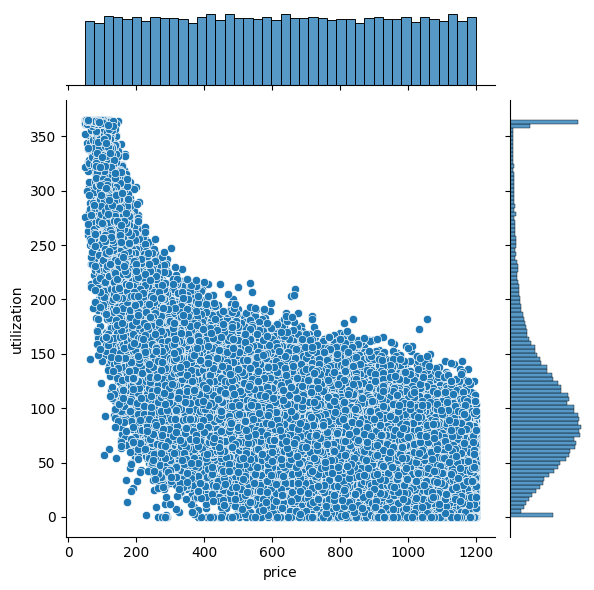

In [45]:

sns.jointplot(x="price", y="utilization", data=AirBnB_utilization_data, kind="scatter"); 

plt.show()

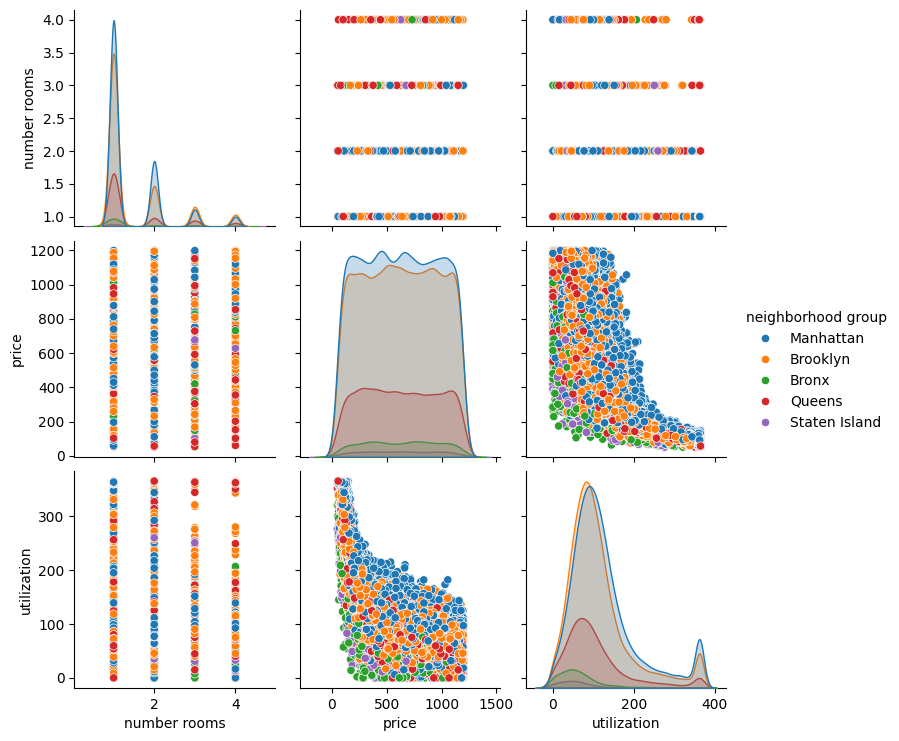

In [46]:

sns.pairplot(AirBnB_utilization_data, vars = ['number rooms','price','utilization'], hue = 'neighborhood group');
 

plt.show()

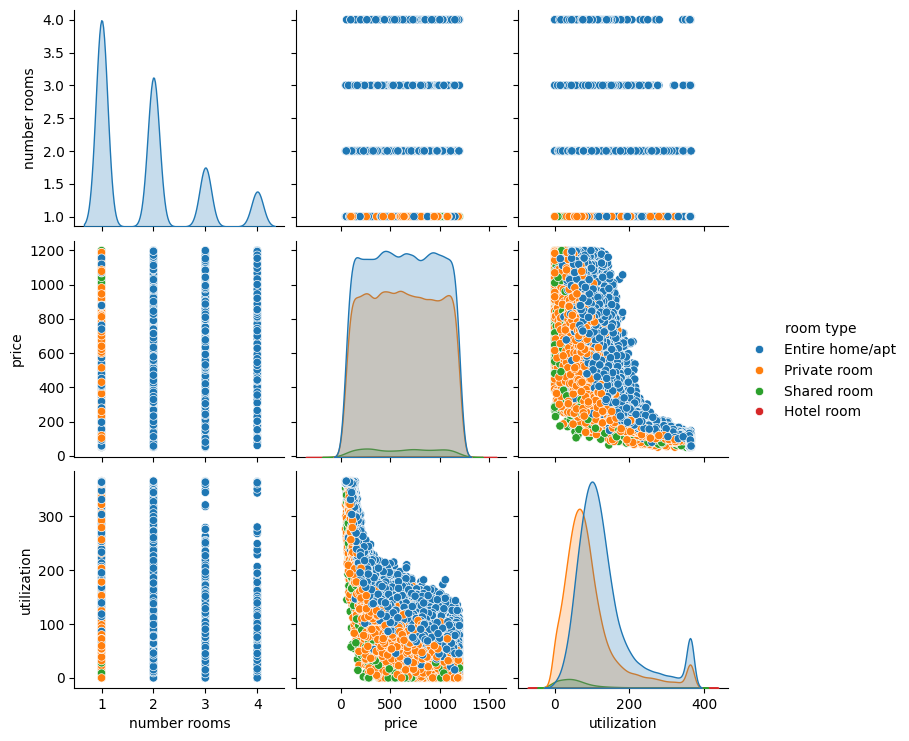

In [47]:

sns.pairplot(AirBnB_utilization_data, vars = ['number rooms','price','utilization'], hue = 'room type');
 
plt.show()

You will investigate the relationship between price and utilization in this subtask. First, you will train different models and choose the one that best predicts utilization for an apartment. Second, you will evaluate which of the proposed prices of decision tree and clustering prices were better, assuming that your model provides the correct utilization. Third, you will conclude your investigation and provide a pricing decision.

### Learning price elasticity
You want to use different supervised learning techniques to learn price elasticity. You decide on linear regression, SVM, and multilayer perceptrons. However, you have to preprocess the data. Use the features of the neighborhood group, the room type, the number of rooms, and the price to predict the utilization. Split into training and testing data (test size 5%).

Prepare the data set by splitting, one-hot encoding, and normalizing.

In [48]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from seaborn import load_dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import preprocessing

In [49]:
#apply the one hot encoder

AirBnB_utilization_data = AirBnB_utilization_data[(AirBnB_utilization_data["number rooms"] == 2) &
                                                  (AirBnB_utilization_data["neighborhood group"] == "Manhattan") &
                                                  (AirBnB_utilization_data["room type"] == "Entire home/apt")
                                                 ]

#Output head

print(AirBnB_utilization_data.head())

transformer = make_column_transformer(
    (OneHotEncoder(), ['room type', 'neighborhood group']),
    remainder='passthrough')

transformed = transformer.fit_transform(AirBnB_utilization_data)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
transformed_df.head()



    number rooms        room type neighborhood group  price  utilization
37             2  Entire home/apt          Manhattan    375   151.259424
43             2  Entire home/apt          Manhattan    387   149.784006
45             2  Entire home/apt          Manhattan    665   108.975573
48             2  Entire home/apt          Manhattan    601    93.537899
64             2  Entire home/apt          Manhattan    823    81.018843


,onehotencoder__room type_Entire home/apt,onehotencoder__neighborhood group_Manhattan,remainder__number rooms,remainder__price,remainder__utilization
0,1.0,1.0,2.0,375.0,151.259424
1,1.0,1.0,2.0,387.0,149.784006
2,1.0,1.0,2.0,665.0,108.975573
3,1.0,1.0,2.0,601.0,93.537899
4,1.0,1.0,2.0,823.0,81.018843


In [50]:
# Normalization using MinMaxScaler

x = transformed_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=transformed_df.columns,index=transformed_df.index)



df_scaled.head()

,onehotencoder__room type_Entire home/apt,onehotencoder__neighborhood group_Manhattan,remainder__number rooms,remainder__price,remainder__utilization
0,0.0,0.0,0.0,0.282609,0.414409
1,0.0,0.0,0.0,0.293043,0.410367
2,0.0,0.0,0.0,0.534783,0.298563
3,0.0,0.0,0.0,0.479130,0.256268
4,0.0,0.0,0.0,0.672174,0.221969


In [51]:
# Transform our apartment data

our_apartment_transformed = transformer.transform(our_apartment.drop(columns=['label']))
our_x = min_max_scaler.transform(our_apartment_transformed)

our_apartment_transformed_df = pd.DataFrame(our_x, columns=transformed_df.columns,index=our_apartment.index)

our_apartment_test = our_apartment_transformed_df.drop(columns=['remainder__utilization'])

our_apartment_test.head()

,onehotencoder__room type_Entire home/apt,onehotencoder__neighborhood group_Manhattan,remainder__number rooms,remainder__price
0,0.0,0.0,0.0,0.565217
1,0.0,0.0,0.0,0.581923
2,0.0,0.0,0.0,-0.034783
3,0.0,0.0,0.0,-0.026087
4,0.0,0.0,0.0,-0.017391


In [52]:
#Splitting dataset
from sklearn.model_selection import train_test_split

#split data into target features and descriptive features
targetFeature_data = AirBnB_utilization_data['utilization']
descriptiveFeature_data = df_scaled[df_scaled.columns.drop('remainder__utilization')]

print(targetFeature_data.head(4))
descriptiveFeature_data.head(4)


37    151.259424
43    149.784006
45    108.975573
48     93.537899
Name: utilization, dtype: float64


,onehotencoder__room type_Entire home/apt,onehotencoder__neighborhood group_Manhattan,remainder__number rooms,remainder__price
0,0.0,0.0,0.0,0.282609
1,0.0,0.0,0.0,0.293043
2,0.0,0.0,0.0,0.534783
3,0.0,0.0,0.0,0.479130


In [53]:
#strategicly split data into test & training data based on the target features
X_train, X_test, y_train, y_test = train_test_split(targetFeature_data, descriptiveFeature_data, random_state=0, test_size = .05)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(6250,)
(6250, 4)
(329,)
(329, 4)


For each technique, use 5-cross-fold validation and assess the performance on the test set. 

#### Regression

Learn a linear regression to predict the utilization of an AirBnB.

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


classifier = LinearRegression()
modelLinearR = classifier.fit(y_train,X_train)

targetFeature_predict_linear_regression = classifier.predict(y_test)
print('Coefficients: \n', classifier.coef_)
print('Intercept: \n', classifier.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(X_test, targetFeature_predict_linear_regression))
print("Mean absolute error: %.2f" % mean_absolute_error(X_test, targetFeature_predict_linear_regression))


Coefficients: 
 [   0.            0.            0.         -209.70916611]
Intercept: 
 237.9188338247472
Mean squared error: 1797.18
Mean absolute error: 32.00


What is the mean absolute error achieved on the test data?

In [55]:
X_linear_regression = y_test.iloc[:]
#y = targetFeature3_predict.iloc[:]

scoring = 'neg_mean_absolute_error'

# 5-fold cross-validation
scores = cross_val_score(classifier, X_linear_regression, targetFeature_predict_linear_regression, scoring=scoring, cv=5)
print(scores)

[-6.56713741e-14 -1.50721186e-14 -7.79443850e-14 -4.02640884e-14
 -2.97334806e-14]


Show (draw!) the price elasticity for your apartment. 

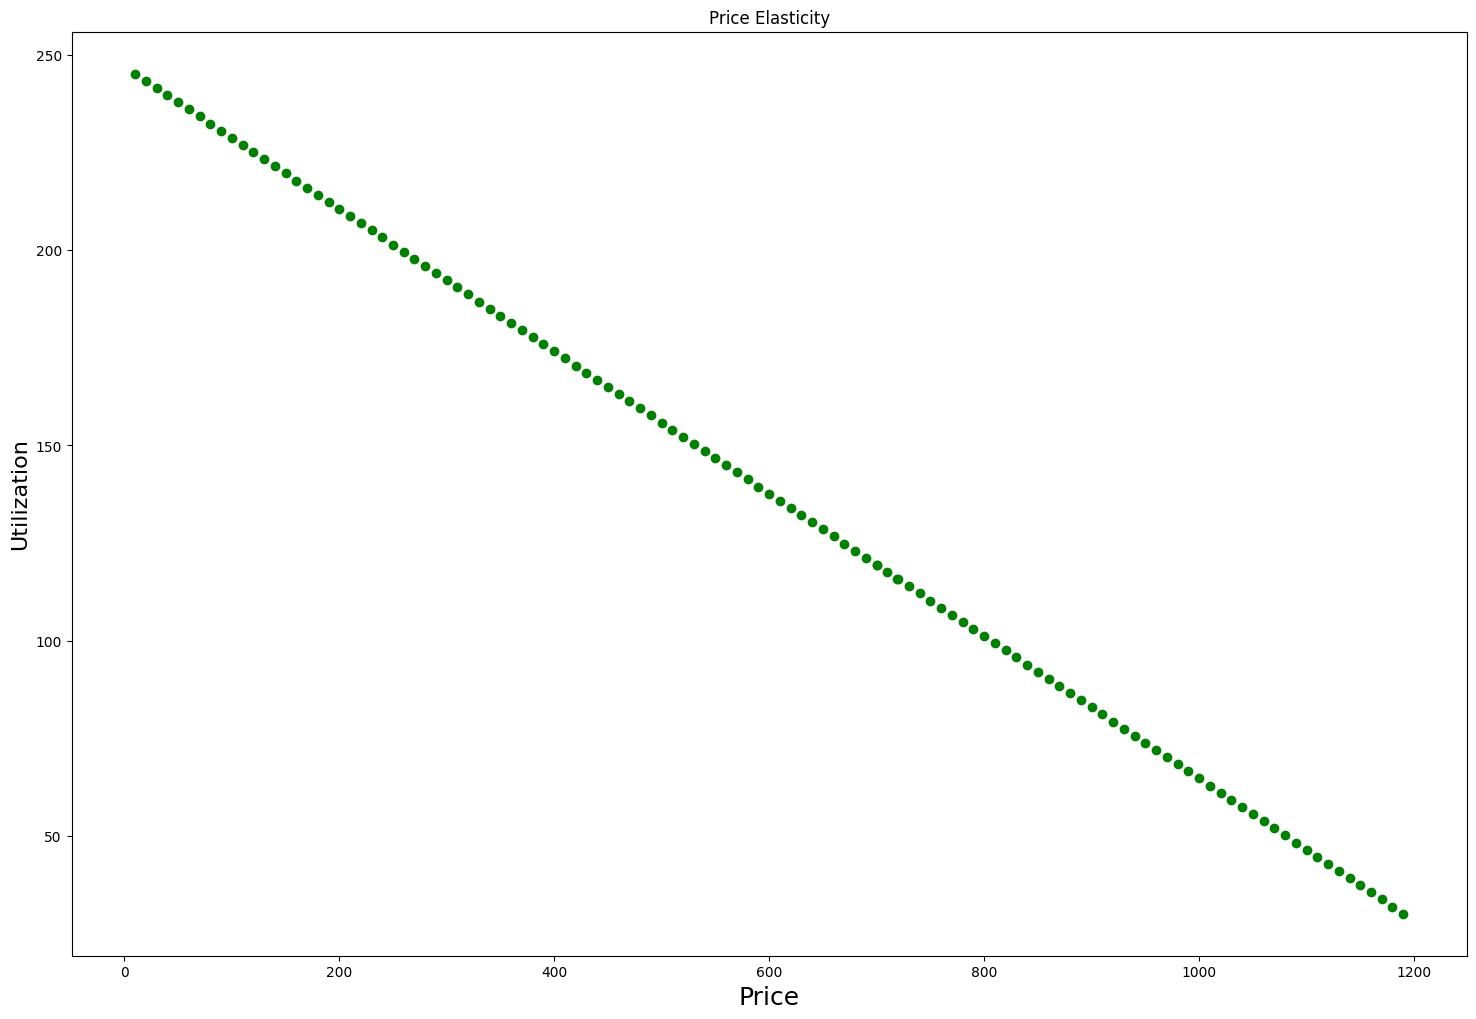

In [56]:
# Your answer goes here

apartment_prediction_linear_regression = classifier.predict(our_apartment_test)

plt.figure(figsize=(18, 12))
plt.scatter(our_apartment["price"], apartment_prediction_linear_regression, color='g')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Utilization', fontsize=16)

plt.title("Price Elasticity")
plt.show()

#### Linear SVR

Train and evaluate a Linear SVR (Support Vector Regression) model.

In [57]:
# Your answer goes here
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from  sklearn.svm import SVR

regressor_linear = SVR(kernel ='linear')
regressor_linear.fit(y_train, X_train)

targetFeature_predict_svr_linear = regressor_linear.predict(y_test)
print('Coefficients: \n', classifier.coef_)
print('Intercept: \n', classifier.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(X_test, targetFeature_predict_svr_linear))
print("Mean absolute error: %.2f" % mean_absolute_error(X_test, targetFeature_predict_svr_linear))


Coefficients: 
 [   0.            0.            0.         -209.70916611]
Intercept: 
 237.9188338247472
Mean squared error: 2141.81
Mean absolute error: 29.89


What is the mean absolute error achieved on the test data?

In [58]:
# Your answer goes here
X_linear_svr = y_test.iloc[:]
#y = targetFeature3_predict.iloc[:]

scoring = 'neg_mean_absolute_error'

# 5-fold cross-validation
scores = cross_val_score(regressor_linear, X_linear_svr, targetFeature_predict_svr_linear, scoring=scoring, cv=5)
print(scores)


[-16.75695461 -14.54161717 -21.94659983 -17.02043009 -21.20026908]


Show (draw!) the price elasticity for your apartment. 

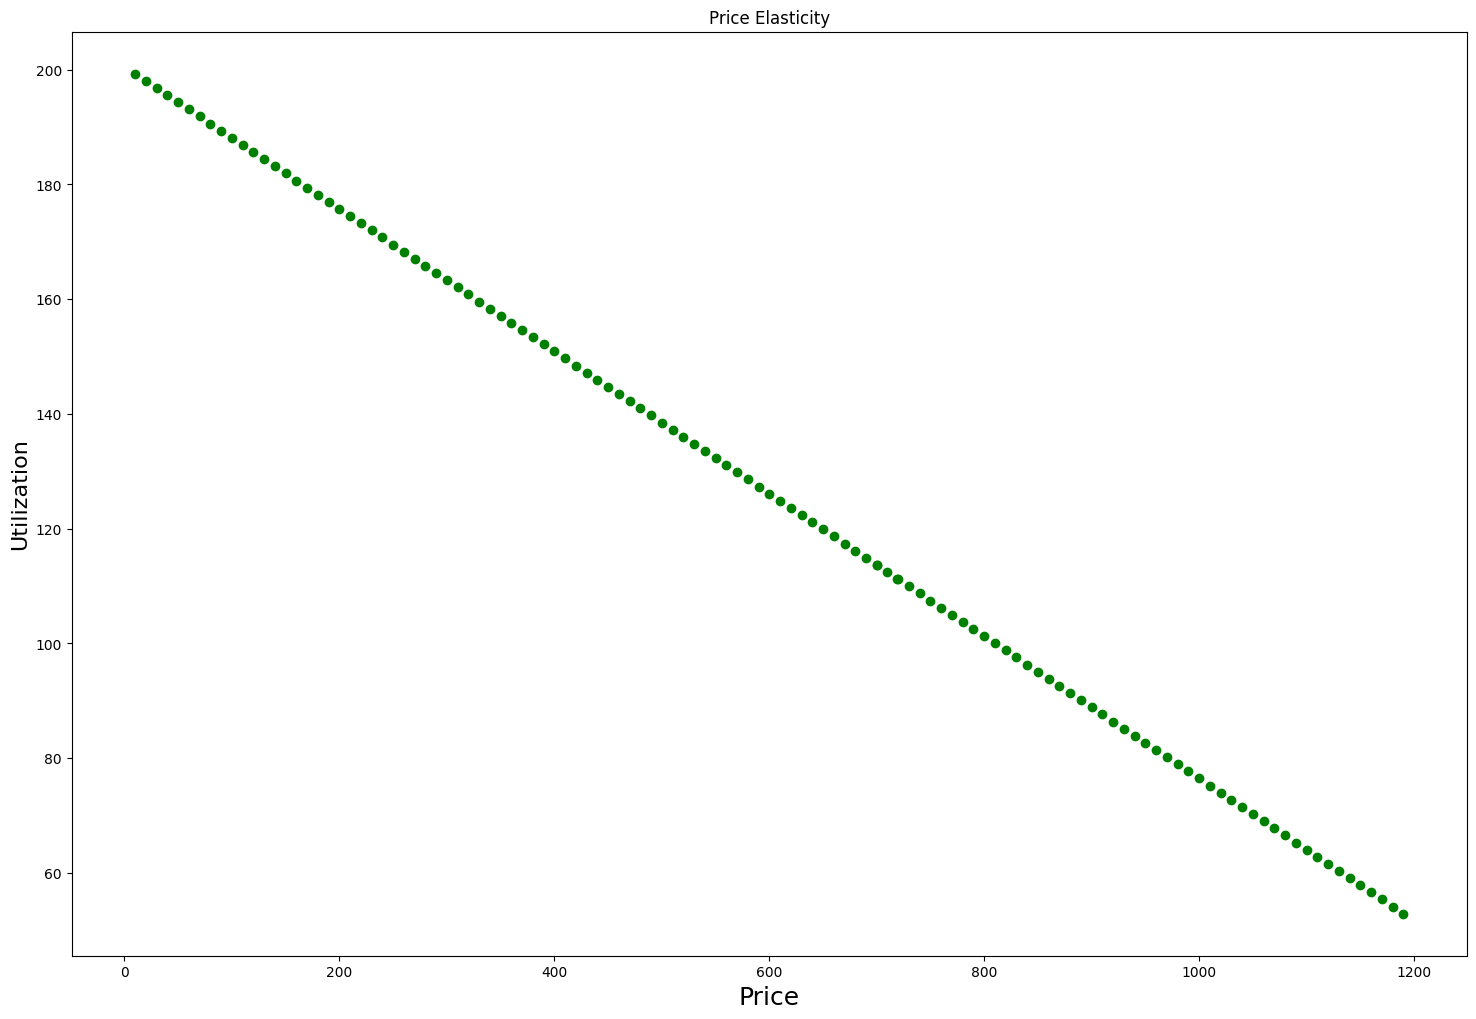

In [59]:
# Your answer goes here

apartment_prediction_svm = regressor_linear.predict(our_apartment_test)

plt.figure(figsize=(18, 12))
plt.scatter(our_apartment["price"], apartment_prediction_svm, color='g')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Utilization', fontsize=16)

plt.title("Price Elasticity")
plt.show()

#### Learning Non-Linear Relationships

You realize that learning linear relationships only provides limited performance. You want to learn non-linear relationships. First, you will learn non-linear relationships using linear regression and kernels. Second, you will use non-linear kernels in the Support Vector Regression. Third, you will use neural networks.

#### Kernels in Regression

Use a transformation of the price and a regression to incorporate non-linear relationships, as learned in the lecture. You can try different kernel functions, but at least you should use one quadratic kernel.

In [60]:
regressor_nonlinear_rbf = SVR(kernel ='rbf')
regressor_nonlinear_rbf.fit(y_train, X_train)

targetFeature_predict_svr_rbf = regressor_nonlinear_rbf.predict(y_test)
print('Coefficients: \n', classifier.coef_)
print('Intercept: \n', classifier.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(X_test, targetFeature_predict_svr_rbf))
print("Mean absolute error: %.2f" % mean_absolute_error(X_test, targetFeature_predict_svr_rbf))



Coefficients: 
 [   0.            0.            0.         -209.70916611]
Intercept: 
 237.9188338247472
Mean squared error: 1228.48
Mean absolute error: 25.74


What is the mean absolute error achieved on the test data?

In [61]:

X_svr_rbf = y_test.iloc[:]
#y = targetFeature3_predict.iloc[:]

scoring = 'neg_mean_absolute_error'

# 5-fold cross-validation
scores = cross_val_score(regressor_nonlinear_rbf, X_svr_rbf, targetFeature_predict_svr_rbf, scoring=scoring, cv=5)
print(scores)

[-11.10823013  -9.74858251 -19.7527052   -8.75617035 -15.28931625]


Show (draw!) the price elasticity for your apartment. 

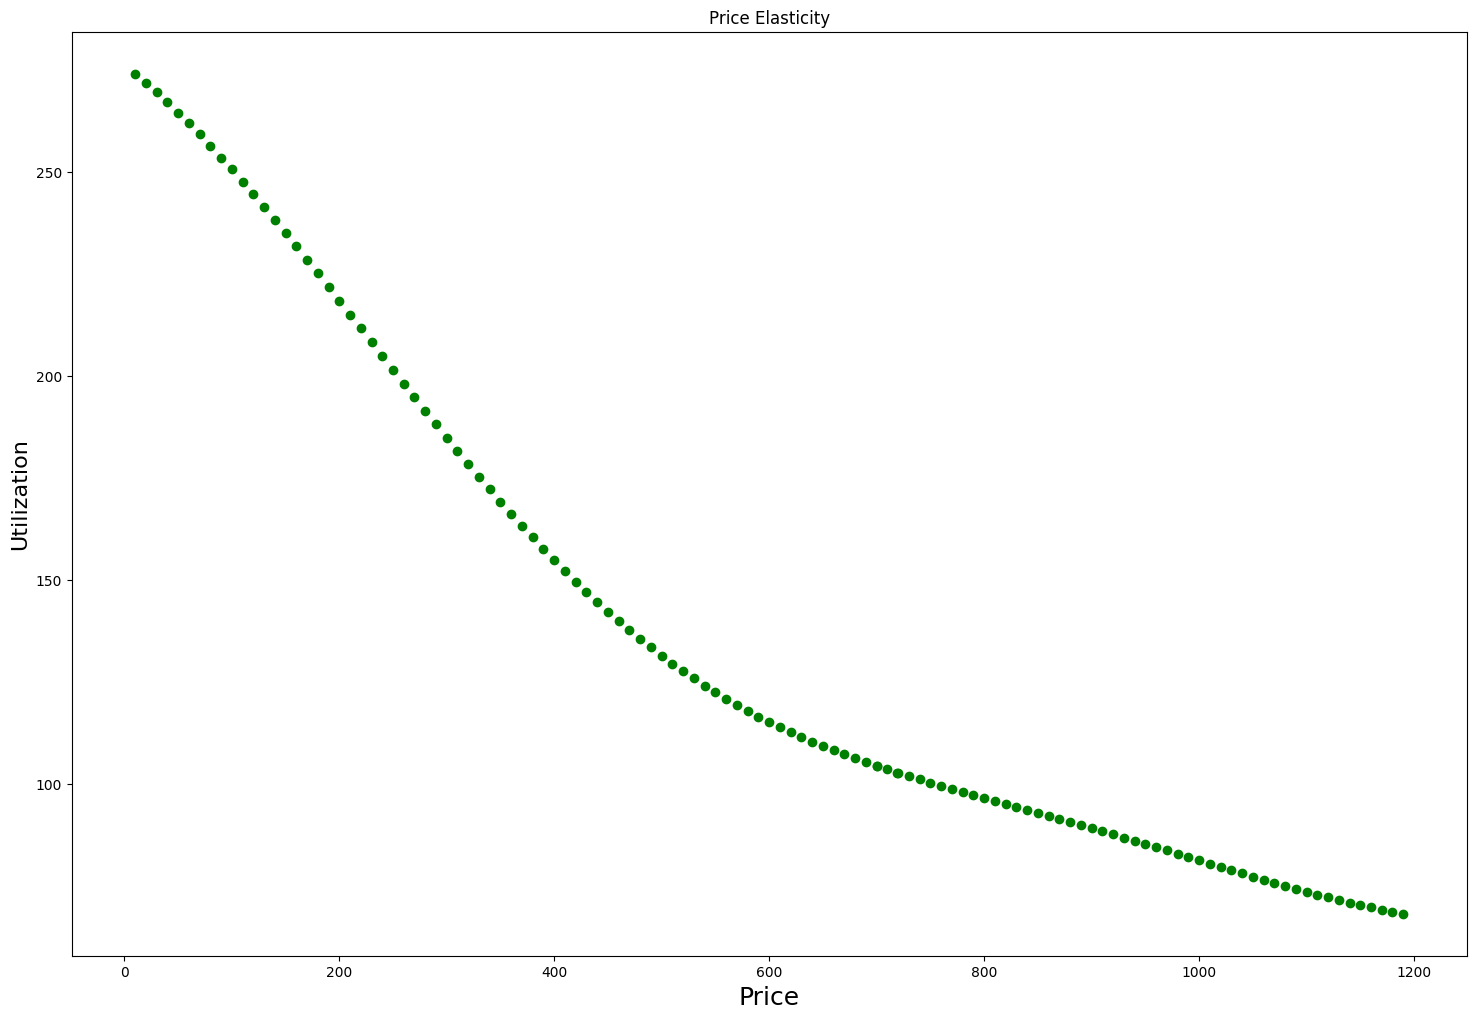

In [62]:
# Your answer goes here

apartment_prediction_rbf = regressor_nonlinear_rbf.predict(our_apartment_test)

plt.figure(figsize=(18, 12))
plt.scatter(our_apartment["price"], apartment_prediction_rbf, color='g')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Utilization', fontsize=16)

plt.title("Price Elasticity")
plt.show()

#### Kernels in SVR

Train and evaluate an SVR (Support Vector Regression) model with different, non-linear kernels. You can limit the size of your training set to 25000 samples to make the problem feasible in computation time.

In [63]:

# Your answer goes here poly
regressor_nonlinear_poly = SVR(kernel ='poly')
regressor_nonlinear_poly.fit(y_train.head(25000), X_train.head(25000))

targetFeature_predict_svr_poly = regressor_nonlinear_poly.predict(y_test)
print('Coefficients: \n', classifier.coef_)
print('Intercept: \n', classifier.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(X_test, targetFeature_predict_svr_poly))
print("Mean absolute error: %.2f" % mean_absolute_error(X_test, targetFeature_predict_svr_poly))



Coefficients: 
 [   0.            0.            0.         -209.70916611]
Intercept: 
 237.9188338247472
Mean squared error: 3337.96
Mean absolute error: 35.14


What is the mean absolute error achieved on the test data?

In [64]:
# Your answer goes here
X_svr_poly = y_test.iloc[:]
#y = targetFeature3_predict.iloc[:]

scoring = 'neg_mean_absolute_error'

# 5-fold cross-validation
scores_svr_poly = cross_val_score(regressor_nonlinear_poly, X_svr_poly, targetFeature_predict_svr_poly, scoring=scoring, cv=5)
print(scores_svr_poly)


[-0.06548896 -0.06013635 -0.07122317 -0.06321496 -0.06870803]


Show (draw!) the price elasticity for your apartment. 

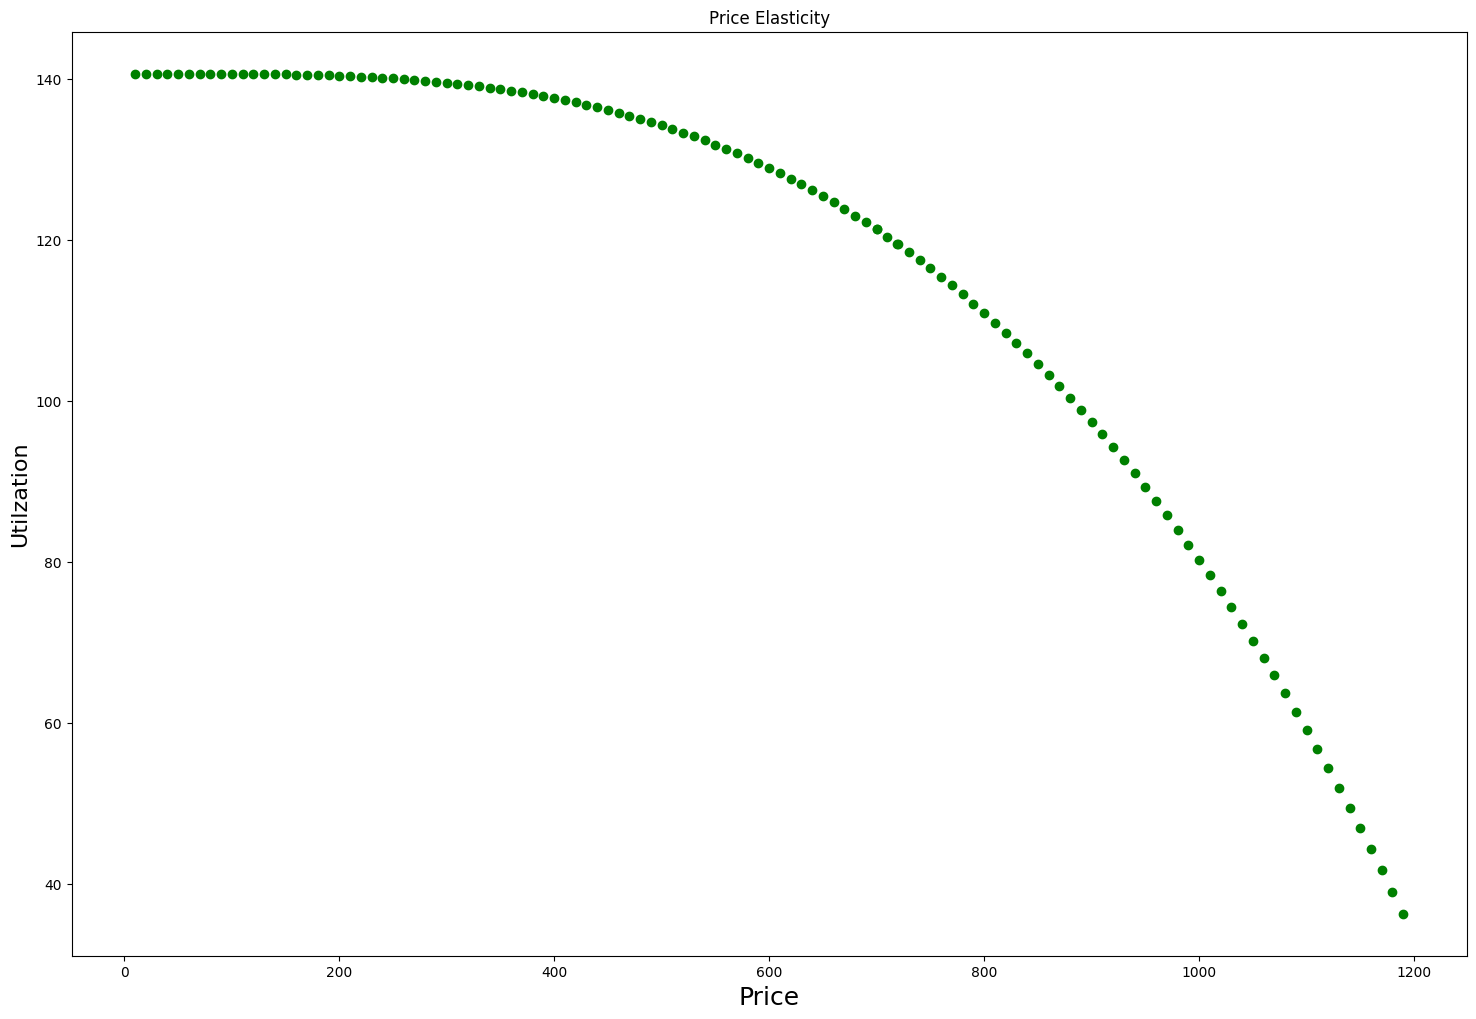

In [65]:
# Your answer goes here

apartment_prediction_svr = regressor_nonlinear_poly.predict(our_apartment_test)

plt.figure(figsize=(18, 12))
plt.scatter(our_apartment["price"], apartment_prediction_svr, color='g')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Utilzation', fontsize=16)

plt.title("Price Elasticity")
plt.show()

What is your conclusion on using kernels?

_Answer:kernel allows us to operate in the original feature space without computing the coordinates of the data in a higher dimensional space.We used linear, rbf, poly kernel and they different error rate and accuracy, rbf gives aproximately 96% accuracy and less error than the others_



#### Neural Network

Learn a neural network (multilayer perceptron) to predict the utilization of an AirBnB.

In [66]:
# Your answer goes here

from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metric

from sklearn.neural_network import MLPRegressor

# train
nn = MLPRegressor(activation='relu')

a = nn.fit(y_train, X_train)

targetFeature_predict_nn = nn.predict(y_test)
print('Coefficients: \n', classifier.coef_)
print('Intercept: \n', classifier.intercept_)
print("Mean squared error: %.2f" % mean_squared_error(X_test, targetFeature_predict_nn))
print("Mean absolute error: %.2f" % mean_absolute_error(X_test, targetFeature_predict_nn))



Coefficients: 
 [   0.            0.            0.         -209.70916611]
Intercept: 
 237.9188338247472
Mean squared error: 1796.78
Mean absolute error: 31.97


What is the mean absolute error achieved on the test data?

In [67]:

# Your answer goes here
X_nn = y_test.iloc[:]
#y = targetFeature3_predict.iloc[:]

scoring = 'neg_mean_absolute_error'

# 5-fold cross-validation
scores_nn = cross_val_score(nn, X_nn, targetFeature_predict_nn, scoring=scoring, cv=5)
print(scores_nn)


d:\IntroductionToDataScienceProject\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\IntroductionToDataScienceProject\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\IntroductionToDataScienceProject\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\IntroductionToDataScienceProject\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[ -99.77647416 -100.32701016 -116.55403202  -92.43636372 -101.66924511]


d:\IntroductionToDataScienceProject\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Show (draw!) the price elasticity for your apartment. 

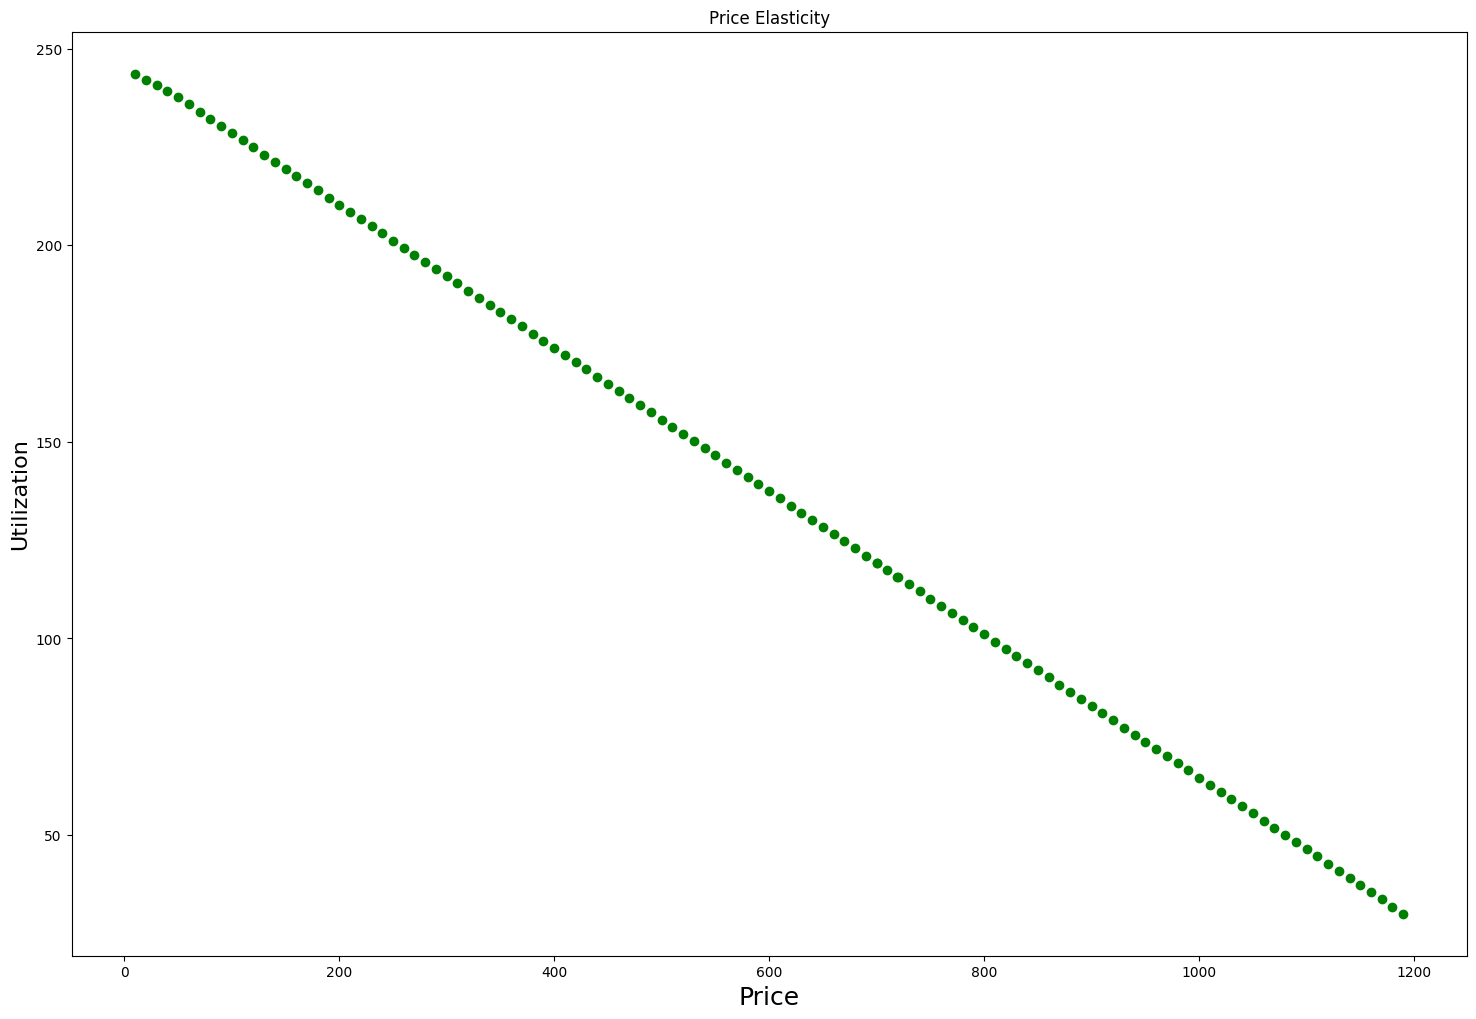

In [68]:
apartment_prediction_nn = nn.predict(our_apartment_test)

plt.figure(figsize=(18, 12))
plt.scatter(our_apartment["price"], apartment_prediction_nn, color='g')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Utilization', fontsize=16)

plt.title("Price Elasticity")
plt.show()

### Profit discrepencies when incorporating price elasticity

Use the model that best captures price elasticity on the testing set. You can assume that this model accurately captures price elasticity, i.e., is the ground truth. What is the better of the two proposed prices? Is the better price the optimal price?

  number rooms neighborhood group        room type       price  utilization  \
0            2          Manhattan  Entire home/apt  700.000000            0   
1            2          Manhattan  Entire home/apt  719.211392            0   

         label        Profit  
0  binary tree  83468.778915  
1   clustering  83241.933362  


C:\Users\Sanjida Ivy\AppData\Local\Temp\ipykernel_6288\1907104916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apartments["Profit"] = apartments["price"] * apartment_prediction


,number rooms,neighborhood group,room type,price,utilization,label,Profit
69,2,Manhattan,Entire home/apt,680.0,0,price 680,83562.040481


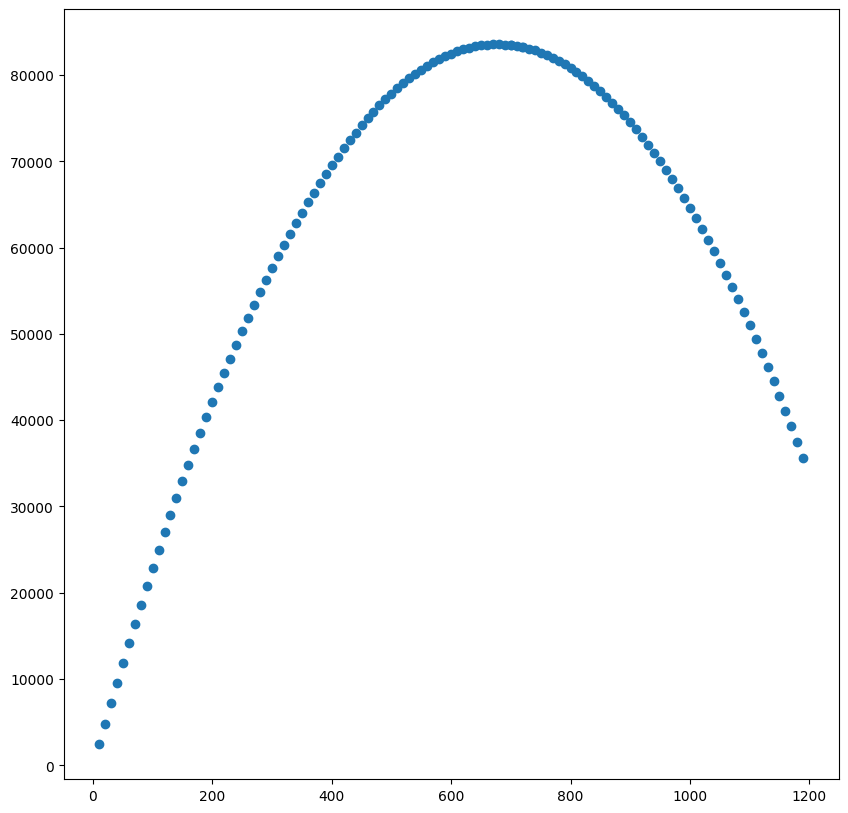

In [69]:
apartments = our_apartment[:2]

apartment_prediction = nn.predict(our_apartment_test[:2])
apartments["Profit"] = apartments["price"] * apartment_prediction
print(apartments)
our_apartment["Profit"] = apartment_prediction_nn * our_apartment["price"]
plt.figure(figsize=(10,10))
plt.scatter(our_apartment["price"], our_apartment["Profit"])
our_apartment[our_apartment['Profit']==our_apartment['Profit'].max()]

_Answer:
The profit for the price predicted by using Decision Trees is with 82334,16 slighly higher than the profit that would be reached with the price predicted when using Clustering. Thus the Decision Tree price is the better price. This also seems to be the optimal price, because this price results in the highest profit.


# Question 4: Conclusion

Summarize your findings and discuss limitations.

From the first task, we can conclude that the prices are evenly distributed over the price range.
We can also conclude that most of the features do not seem to have an influence
on the price. One feature that definitely has an influence on the price is the number of rooms. Here we can
observe that more rooms tend to be more expensive. Further analysis also showed that the combination of two
different features could give some further insights. The combination of the number of rooms with the room type and
the combination of the room type with the neighborhood group can give some further insights into the pricing 
decision. Thus it seems to be beneficial to focus on the features number of rooms, room type, and neighborhood group
to come to a pricing decision.

For second task we can recap the comments on the price predictions. The binary tree is quite limited due to bins and their range, while the clustering may produce beter results. The clustering is limited by choice of the number of clusters. Changing the number of clusters can change the price range.

_To predict the price elasticity we first used Linear Regression which is great tool to analyze the relationships among the variables but it isn’t recommended because it over-simplifies our real problem by assuming linear relationship among the variables, it also gives less accuracy and higher error rate
In SVR we used different kernel. compare to linear kernel we get more accurate value in non-linear kernel. Neural Network is giving better results on Price elasticity_ 

